# Neuroscience of Learning, Memory, Cognition Project Part 1
## by Reza Nayeb Habib
### Fall Semester 2024 - 2025

In [31]:
import mne
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import spectrogram
import copy
from scipy.interpolate import interp1d

# Importing the data
---
This code section imports EEGLAB

In [32]:
%%capture
# capture silences the cell
control_index = [510, 516, 568, 576, 577]
depressed_index = [590, 592, 594, 595, 602]

channels = ["FPZ", "F7", "F3", "FZ", "F4", "F8", "T7",
            "C3", "CZ", "C4", "T8", "P7", "P3", "PZ", "P4", "P8", "OZ"]

# Define file types and create dictionaries to hold data
file_types = ["reward", "punishment", "stimulus", "action"]
data_groups = {"control": control_index, "depressed": depressed_index}
all_data = {group: {ftype: {} for ftype in file_types} for group in data_groups}

''' 
Loop over groups, file types, and subject indices to load data 
Every all_data[group][ftype][i] contains one mne epochs object
'''
for group, indices in data_groups.items():
    for ftype in file_types:
        for i in indices:
            addr = f"preprocessed/{group}/subject{i}/s{i}_{ftype}.set"
            print(addr)  # [DEBUG]
            data = mne.read_epochs_eeglab(addr, events=None, event_id=None, eog=(),
                                          uint16_codec=None, montage_units='auto', verbose=False)
            all_data[group][ftype][i] = data.pick(channels)

# Z-Score Calculation
Because multiple EEG data can have slightly different voltage ranges and we want to normalize them on every channel to compare (and add them together in ERP calculation), so we compute the data's Z-Score and use that as the basis of our further calculations.
The formula for Z-Score calculation is as follows:
$$ x_{zscore}(t) = \frac{x(t) - mean(x)}{std(x)} $$
---
The function ``zscore_epochs`` gets the epochs and replaces data points with their Z-score

In [33]:
def zscore_epochs_internal(epochs, print_indices=None):
    """
    calculates Z-score for the given epochs and returns the new Z-socre data
    print_indices is for [DEBUG] 
    """
    data = epochs.get_data()  # Get the raw data as a NumPy array
    times = epochs.times  # Required for rescale
    
    # Apply MNE's rescale with mode 'zscore' and baseline=None
    data_zscore = mne.baseline.rescale(data, times=times, baseline=(None,None), mode='zscore', copy=True)
    # [DEBUG] shows the value at those indices before and after z-score calculation
    if print_indices:
        print(f"Original value at {print_indices}: {data[print_indices]}")
        print(f"Z-scored value at {print_indices}: {data_zscore[print_indices]}")
        print("-----")
    
    z_epochs = copy.deepcopy(epochs)
    # Modify the original Epochs object with transformed data
    z_epochs._data = data_zscore  # Replace raw data with Z-scored data
    return z_epochs



# Create a new dictionary to store the Z-scored data
all_data_zscore = {group: {ftype: {} for ftype in file_types} for group in data_groups}

# Loop over all groups, conditions, and indices
for group, indices in data_groups.items():
    for ftype in file_types:
        for i in indices:
            # Apply the Z-score transformation using MNE's rescale internally
            epochs = all_data[group][ftype][i].copy()  # Use .copy() to avoid altering original data
            
            # Specify the indices to print (epoch, channel, timepoint)
            print_indices = (0, 1, 5)  # [DEBUG]
            all_data_zscore[group][ftype][i] = zscore_epochs_internal(epochs, print_indices=print_indices)


Applying baseline correction (mode: zscore)
Original value at (0, 1, 5): 3.7318322658538817e-06
Z-scored value at (0, 1, 5): 0.4792839590408193
-----
Applying baseline correction (mode: zscore)
Original value at (0, 1, 5): -2.5327031612396238e-06
Z-scored value at (0, 1, 5): -0.20712790192929842
-----
Applying baseline correction (mode: zscore)
Original value at (0, 1, 5): -2.850767374038696e-06
Z-scored value at (0, 1, 5): -0.31088139979305157
-----
Applying baseline correction (mode: zscore)
Original value at (0, 1, 5): 4.0972319245338437e-07
Z-scored value at (0, 1, 5): 0.07769338176987103
-----
Applying baseline correction (mode: zscore)
Original value at (0, 1, 5): 1.6706634521484375e-05
Z-scored value at (0, 1, 5): 1.8306313006388948
-----
Applying baseline correction (mode: zscore)
Original value at (0, 1, 5): 1.7167303562164305e-06
Z-scored value at (0, 1, 5): 0.3615429472487483
-----
Applying baseline correction (mode: zscore)
Original value at (0, 1, 5): 2.2331886291503906e-0

C:\Users\Reza\AppData\Local\Temp\ipykernel_8732\3688348618.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


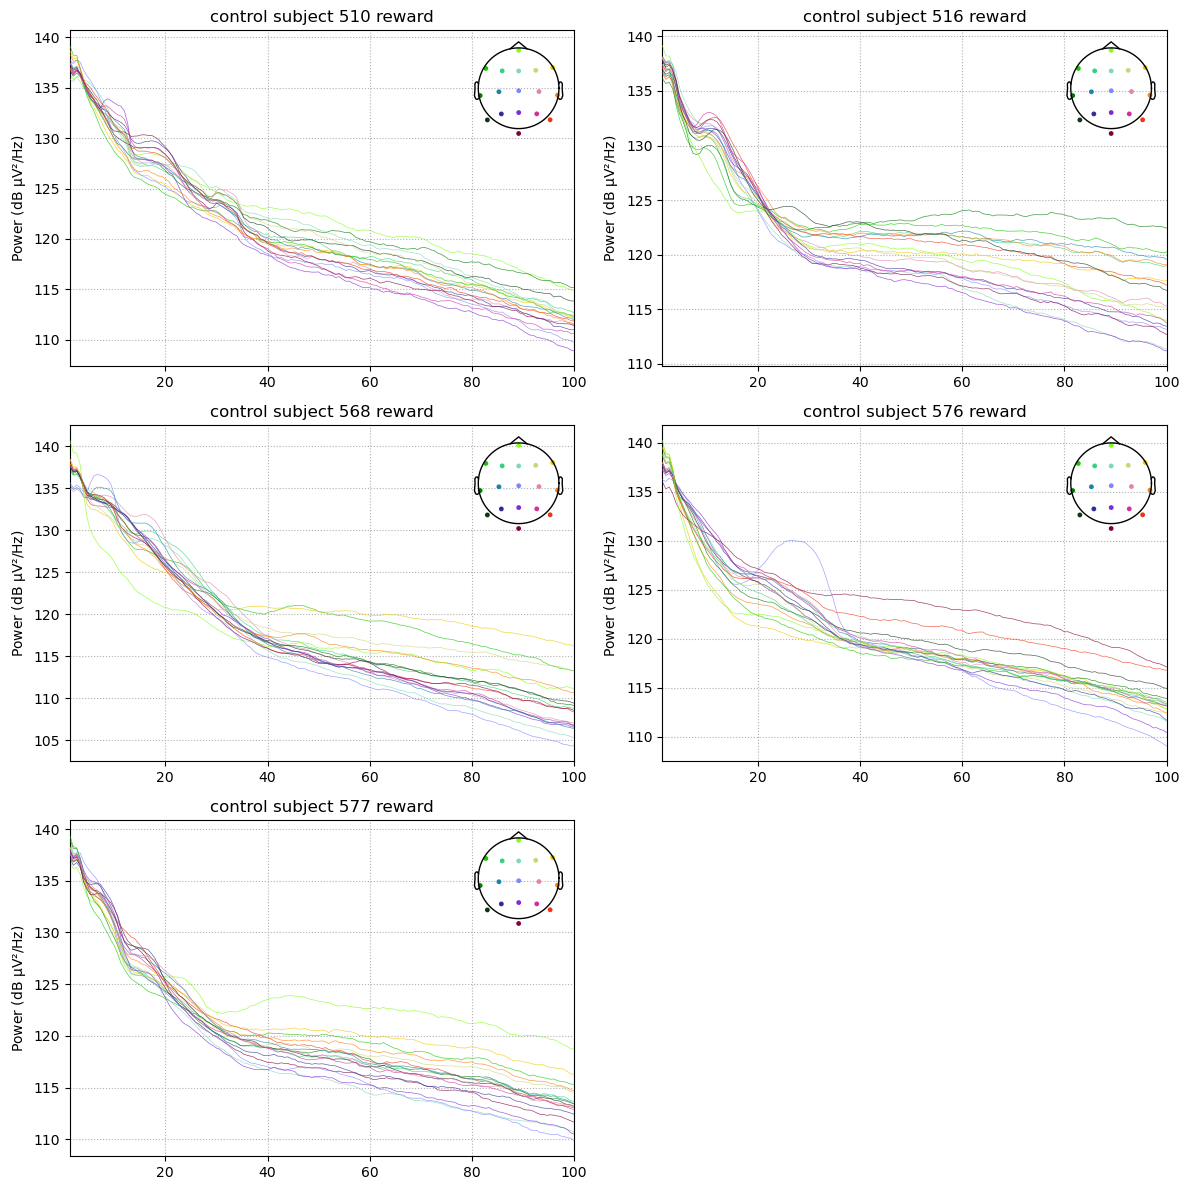

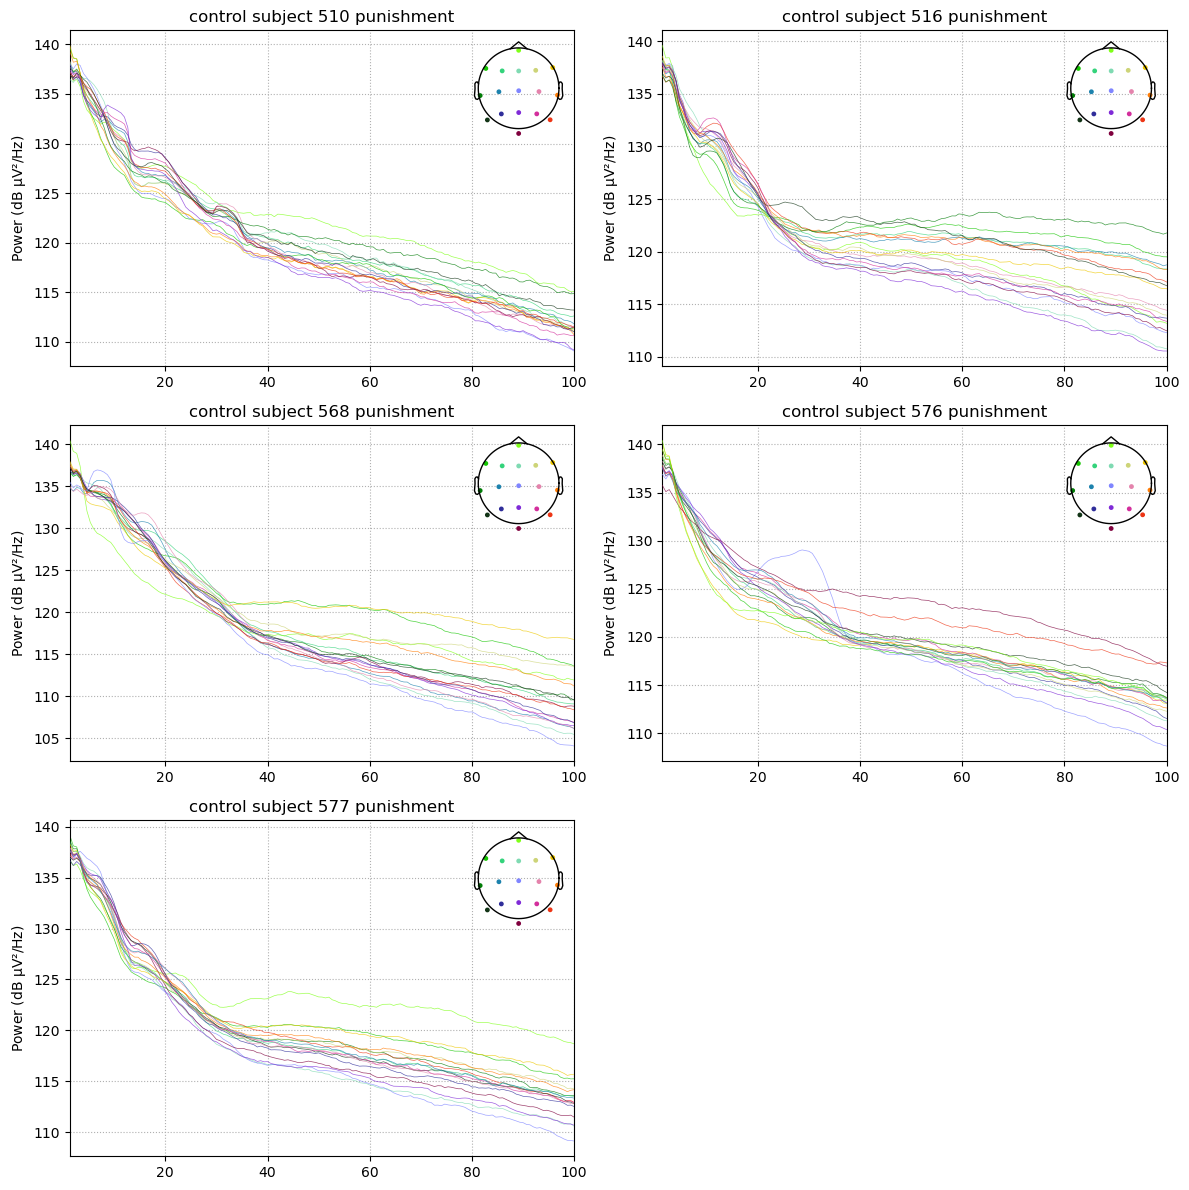

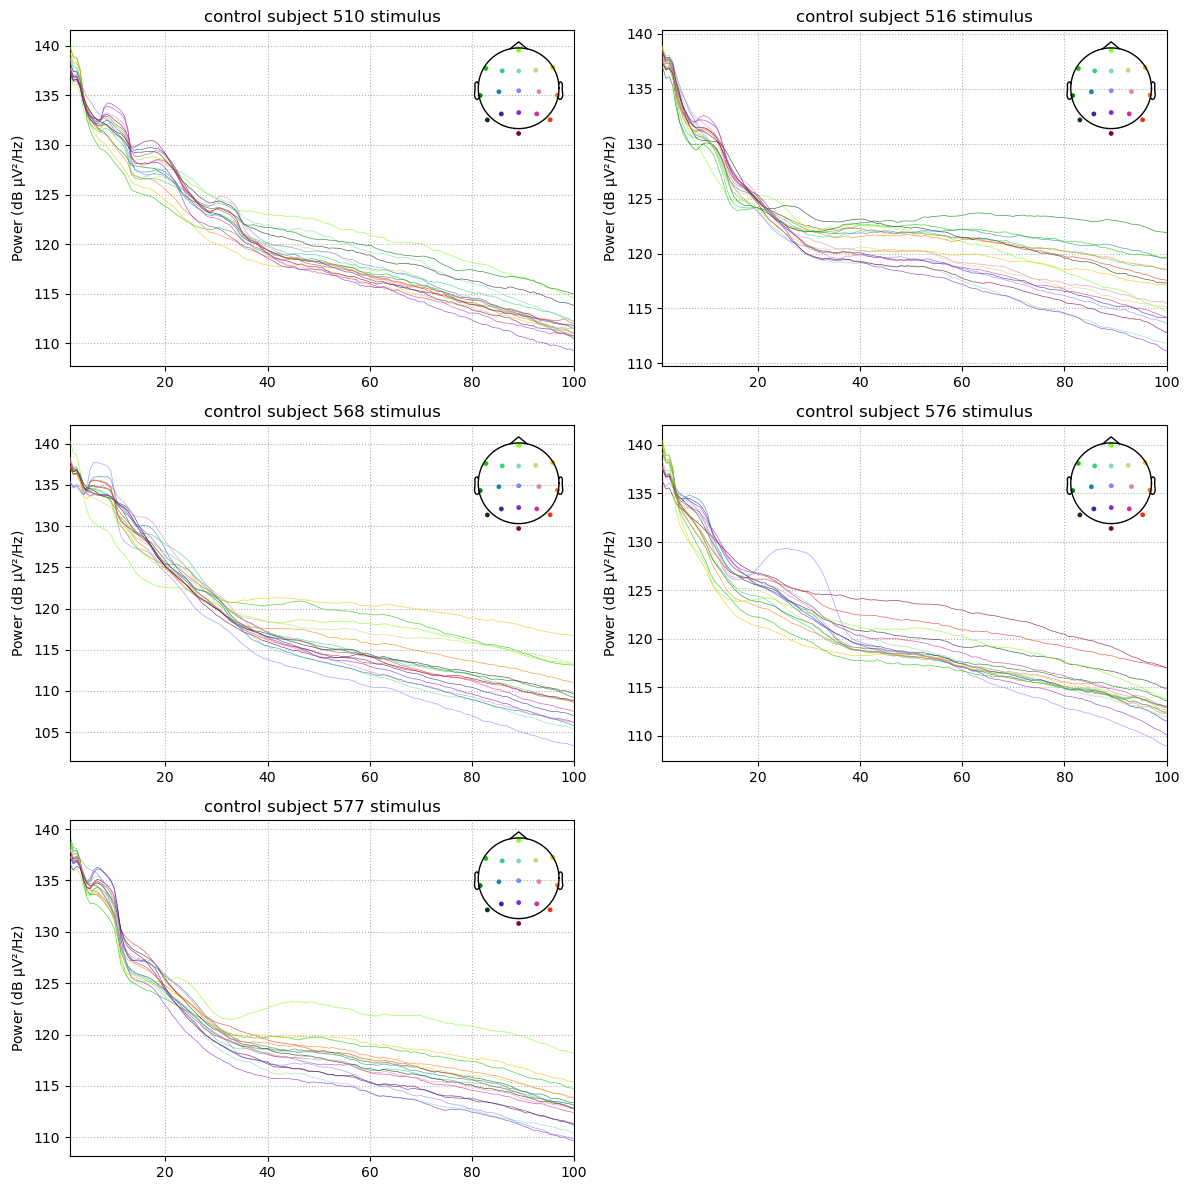

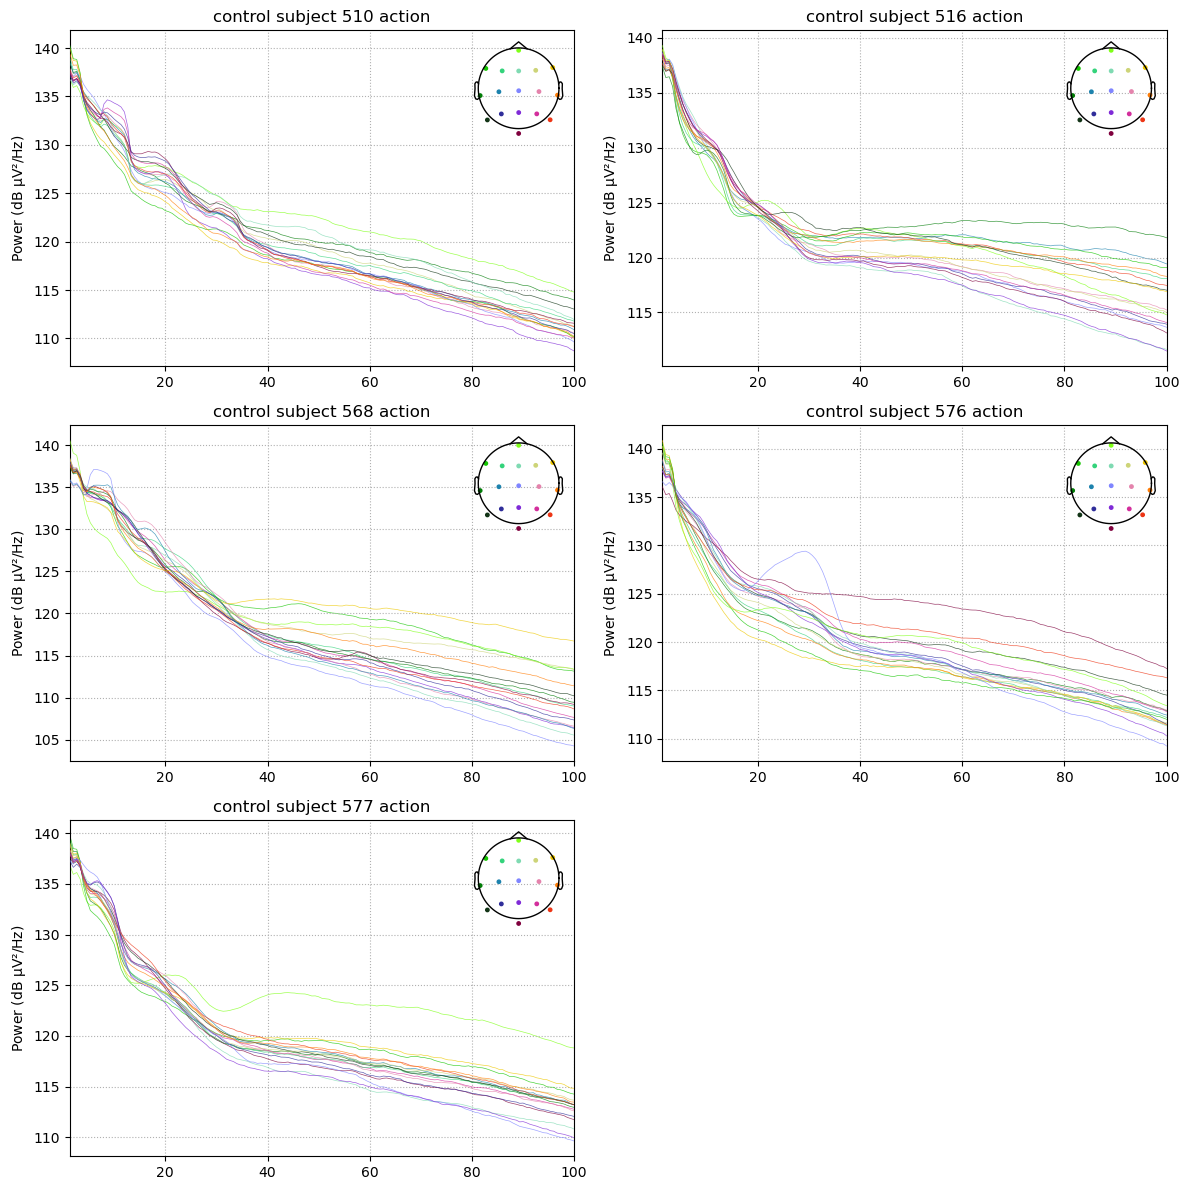

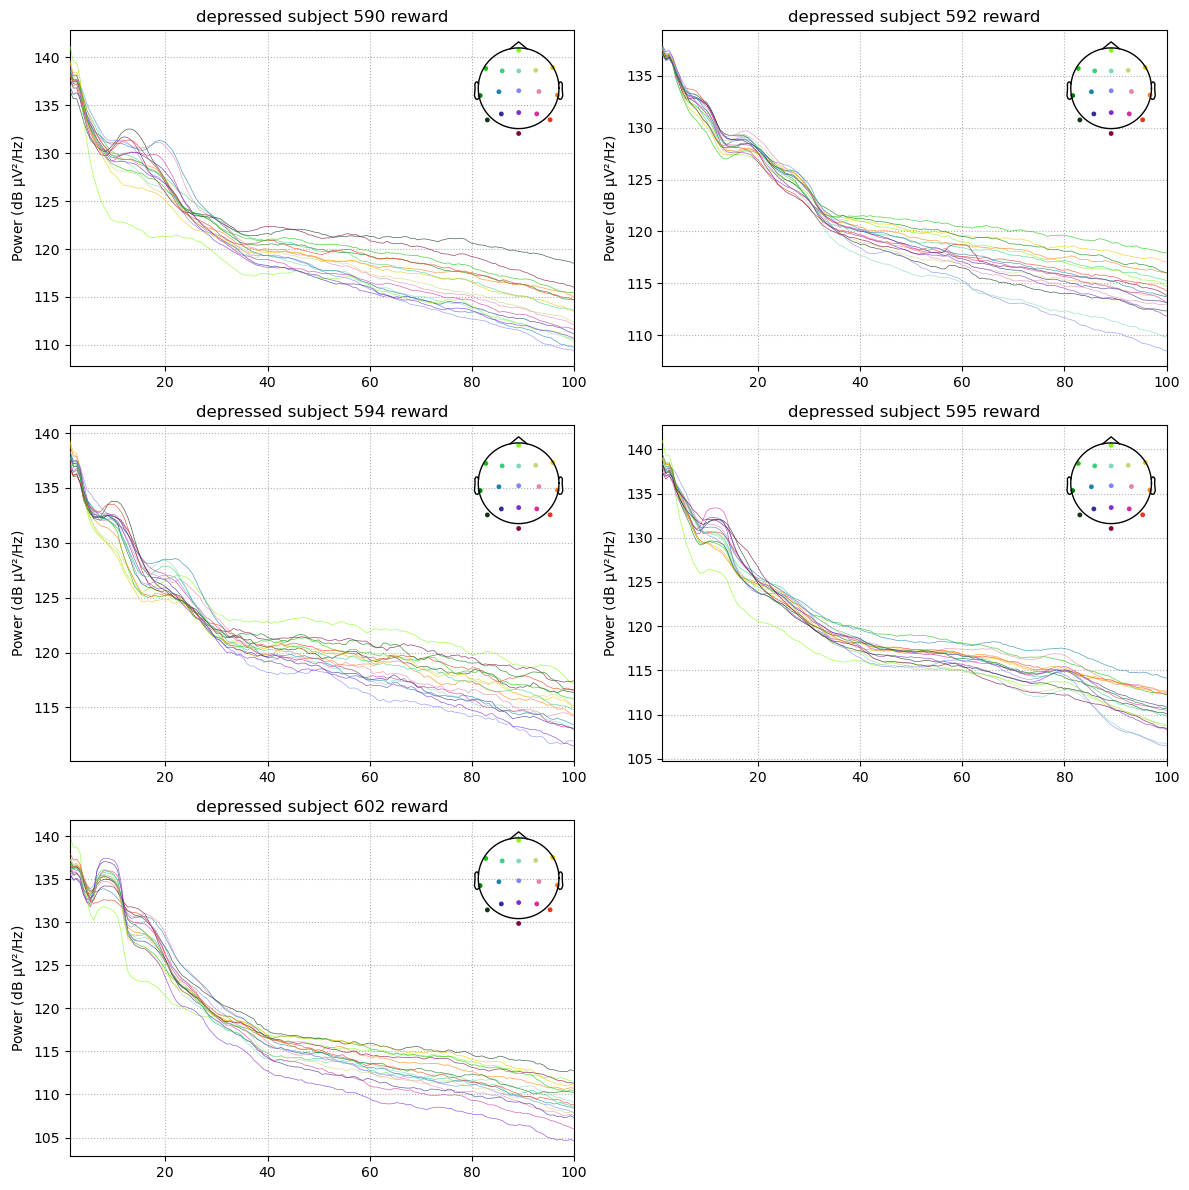

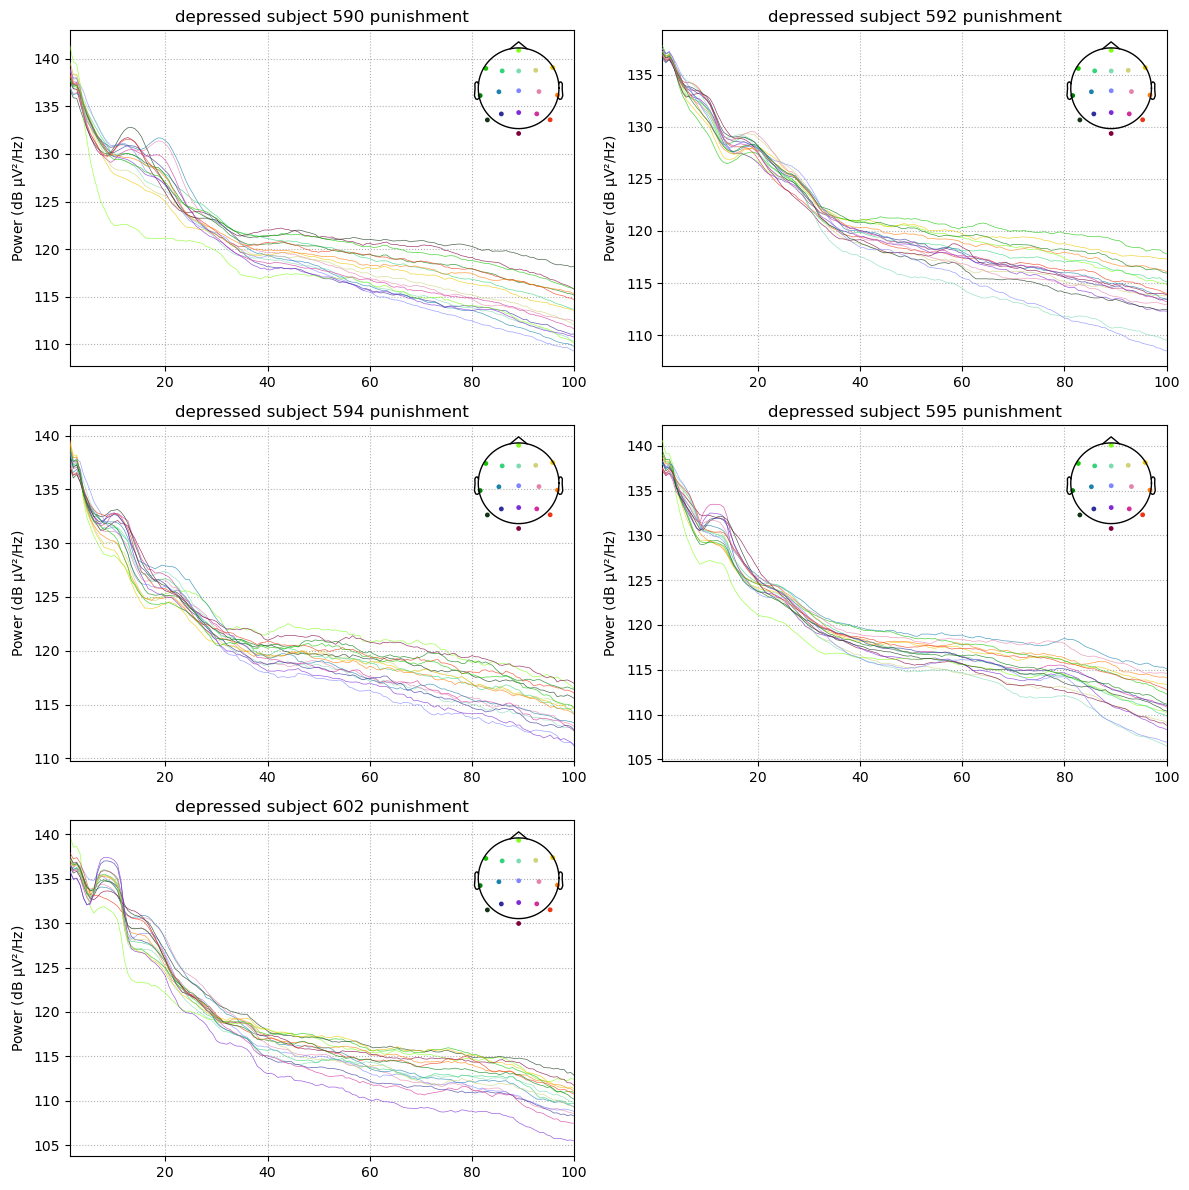

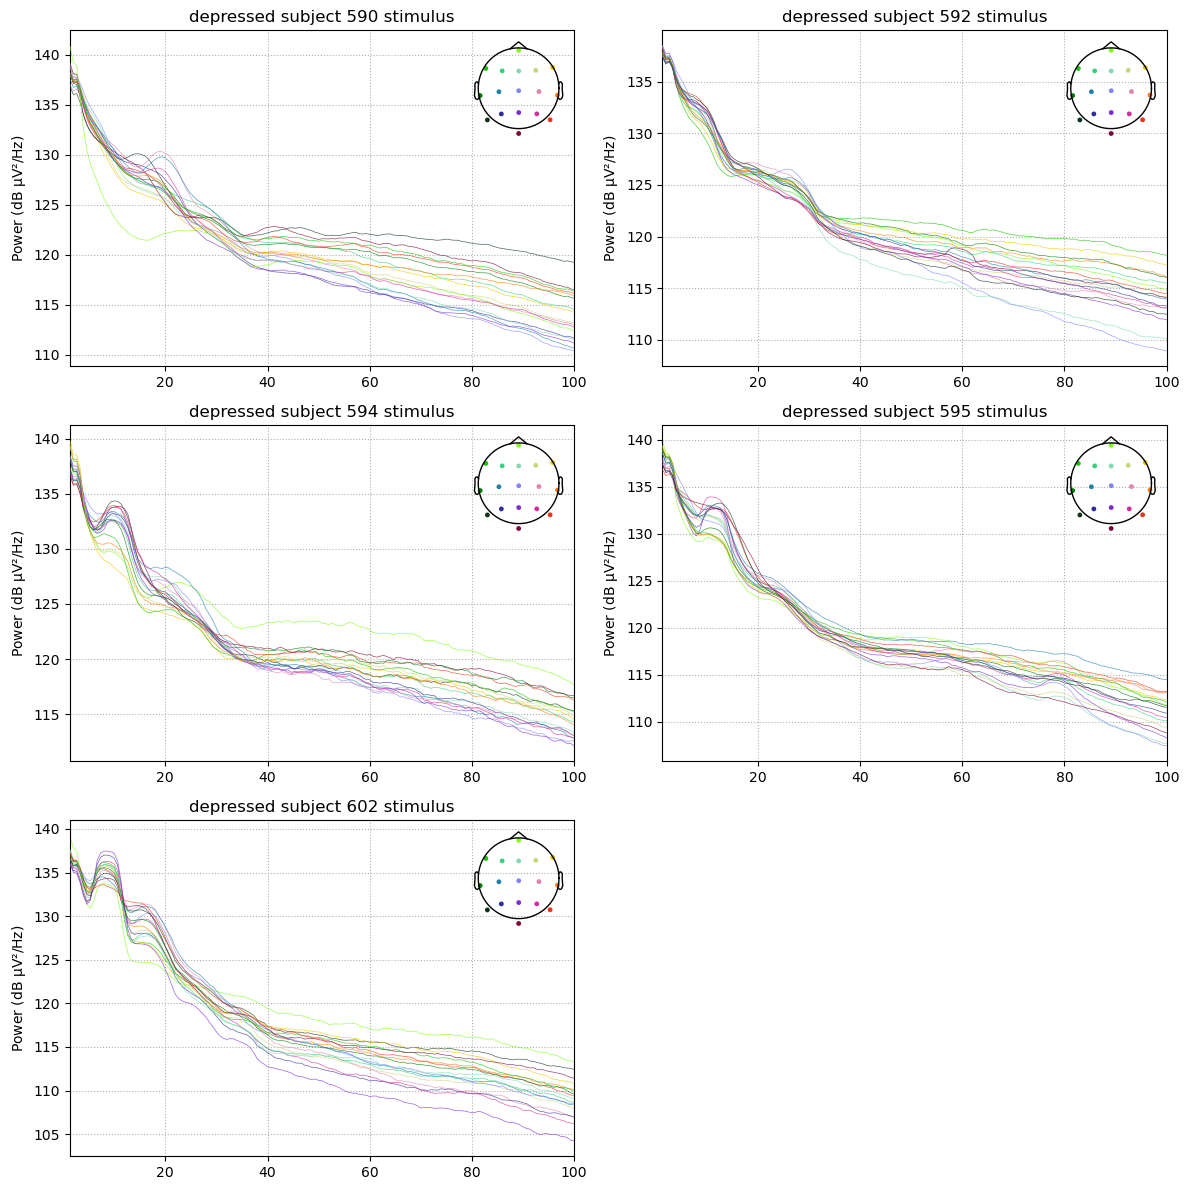

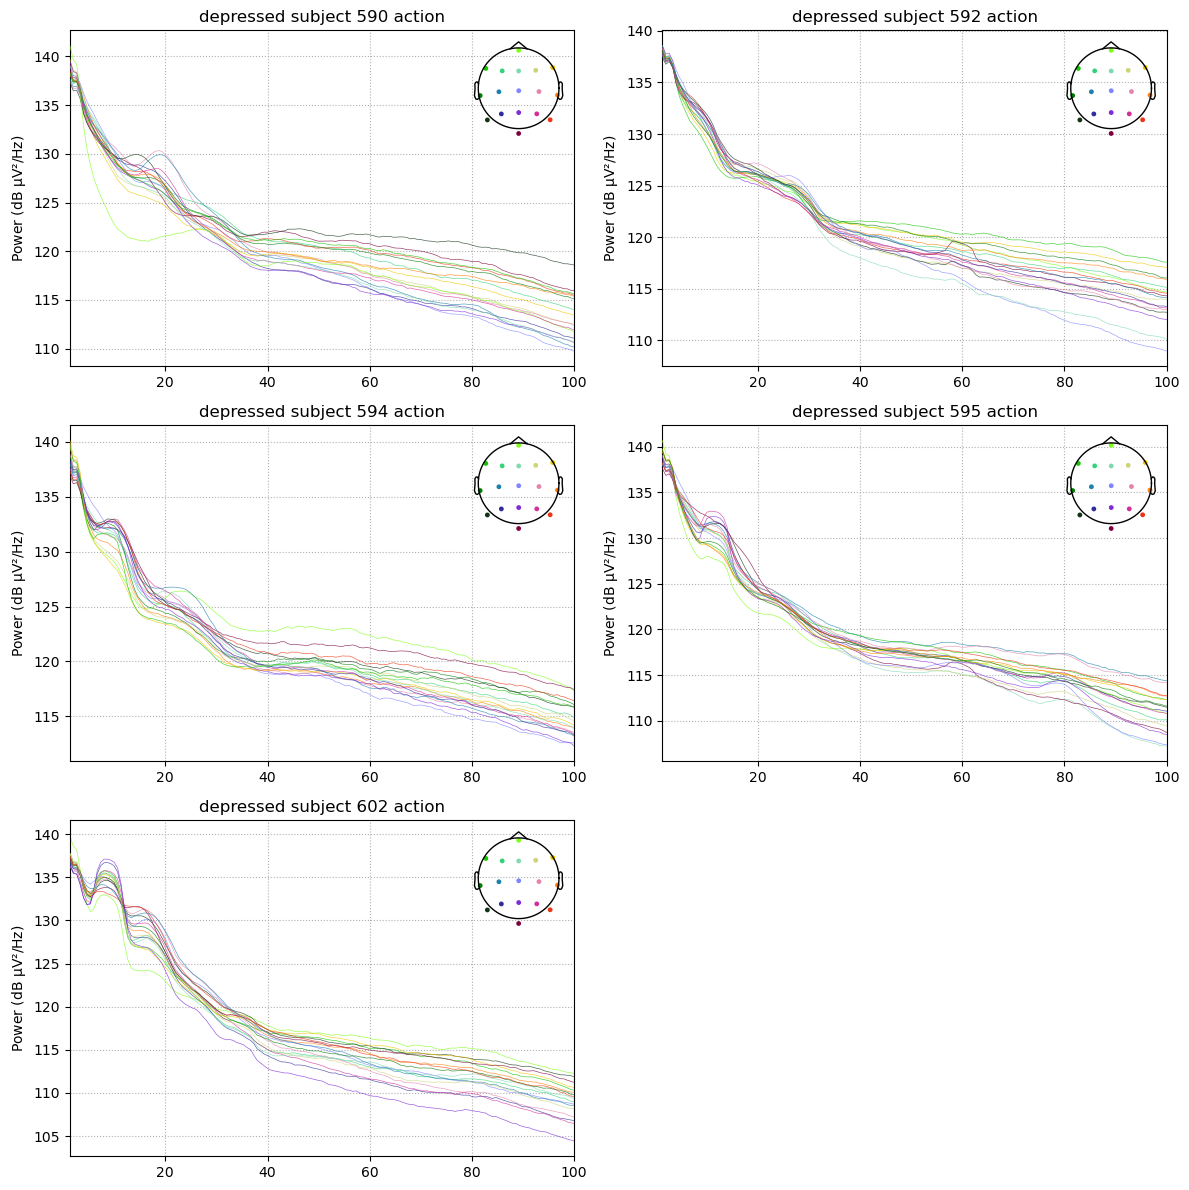

In [34]:
# Save the current log level
original_log_level = mne.get_config('MNE_LOGGING_LEVEL')
mne.set_log_level("ERROR")  # Suppress logs

# Loop over each group and condition to plot
for group in data_groups:
    for condition in file_types:
        # Create a 3x2 grid to fit 5 subjects, leaving one subplot empty
        fig, axes = plt.subplots(3, 2, figsize=(12, 12))
        axes = axes.flatten()

        # Select the appropriate indices for the group
        indices = control_index if group == "control" else depressed_index

        # Plot each subject's data
        for i, index in enumerate(indices):
            # Plot the PSD directly using plot_psd with the ax argument
            all_data_zscore[group][condition][index].plot_psd(fmin=1, fmax=100, ax=axes[i], show=False)
            axes[i].set_title(f"{group} subject {index} {condition}")

        # Hide the last subplot as it’s not needed
        axes[-1].axis("off")

        plt.tight_layout()
        plt.show()

# Restore the original log level
mne.set_log_level(original_log_level)

In the following cell we plot both the Z-Score and original data for a example data to double check if the code is working.

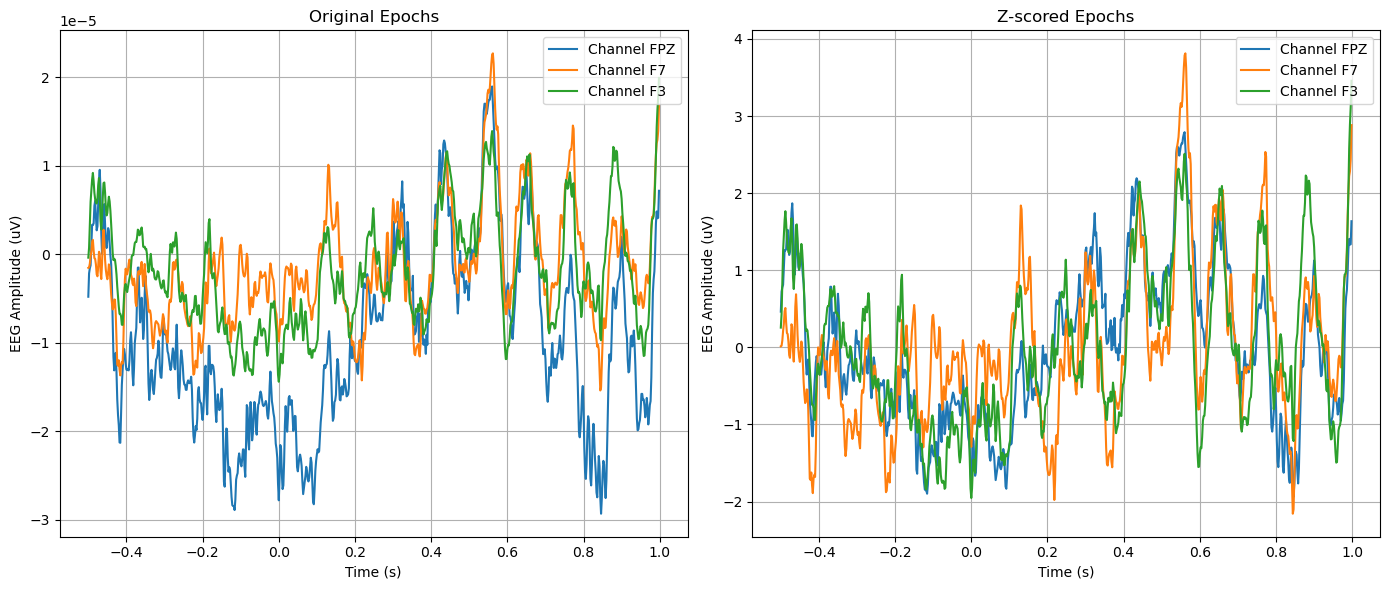

In [35]:
epochs = all_data["depressed"]["reward"][602]

e = all_data_zscore["depressed"]["reward"][602]

# Get the data and time values for both original and Z-scored data
data_original = epochs.get_data()  # Shape: (n_epochs, n_channels, n_times)
data_zscore = e.get_data()  # Shape: (n_epochs, n_channels, n_times)
times = epochs.times  # Array of time points corresponding to the data

# Set up the figure and axes (1x2 grid)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the original data
axes[0].set_title("Original Epochs")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("EEG Amplitude (uV)")
for ch_idx in range(3):  # Loop through the first 3 channels
    axes[0].plot(times, data_original[0, ch_idx, :], label=f"Channel {channels[ch_idx]}")
axes[0].legend(loc='upper right')
axes[0].grid(True)

# Plot the Z-scored data
axes[1].set_title("Z-scored Epochs")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("EEG Amplitude (uV)")
for ch_idx in range(3):  # Loop through the first 3 channels
    axes[1].plot(times, data_zscore[0, ch_idx, :], label=f"Channel {channels[ch_idx]}")
axes[1].legend(loc='upper right')
axes[1].grid(True)

# Adjust layout and show the figure
plt.tight_layout()
plt.show()


# Event Related Potential (ERP)

Single EEG signals in reaction to an event is often too noisy and brain signals have a decent amount of randomness to give any useful data to us to analyze, therefore we often repeat the experiment several times on multiple subjects and average on them to find the Event Related Potential (ERP). This way noise is minimized and we have a data that can be used for further analysis and deductions.

---

The function ``ERP_onlist`` receives an mne epoch item as its input and gives the average of those epochs as its output.

In [36]:
def ERP_onlist(epochs, trial_list=None):
    """
    Calculates ERP from the selected trials of the given EEG data.
    
    Parameters:
    - epochs: The EEG data from which ERP is calculated (MNE Epochs object).
    - trial_list: A list of trial indices to include for ERP calculation. If None, all trials are used.
    
    Returns:
    - erp: The ERP object for the selected trials.
    """
    if trial_list is None:
        trial_list = range(len(epochs))  # Default to all
    
    # Ensure the trial list is not empty and doesn't exceed the number of available epochs
    if len(trial_list) == 0:
        raise ValueError("trial_list must not be empty.")
    if max(trial_list) >= len(epochs):
        raise ValueError(f"trial_list contains indices out of range. Maximum index: {max(trial_list)}")

    epochs_subset = epochs[trial_list]
    erp = epochs_subset.average()
    return erp


The following code calculates the ERP of FZ and PZ for one depressed and one depressed subjects for different sizes of trials. It can be seen that the larger the trials get the more noise is removed and the ERP converges to a more stable shape.

C:\Users\Reza\AppData\Local\Temp\ipykernel_8732\2009727103.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


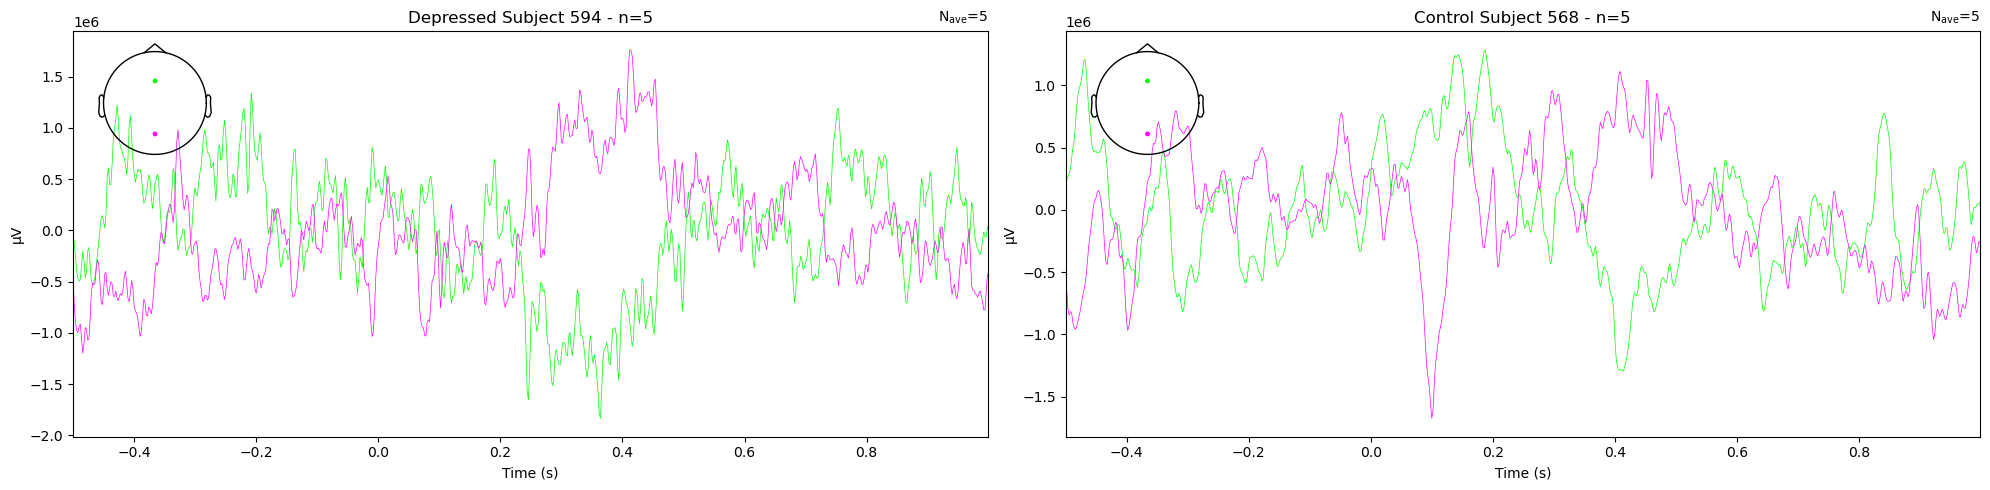

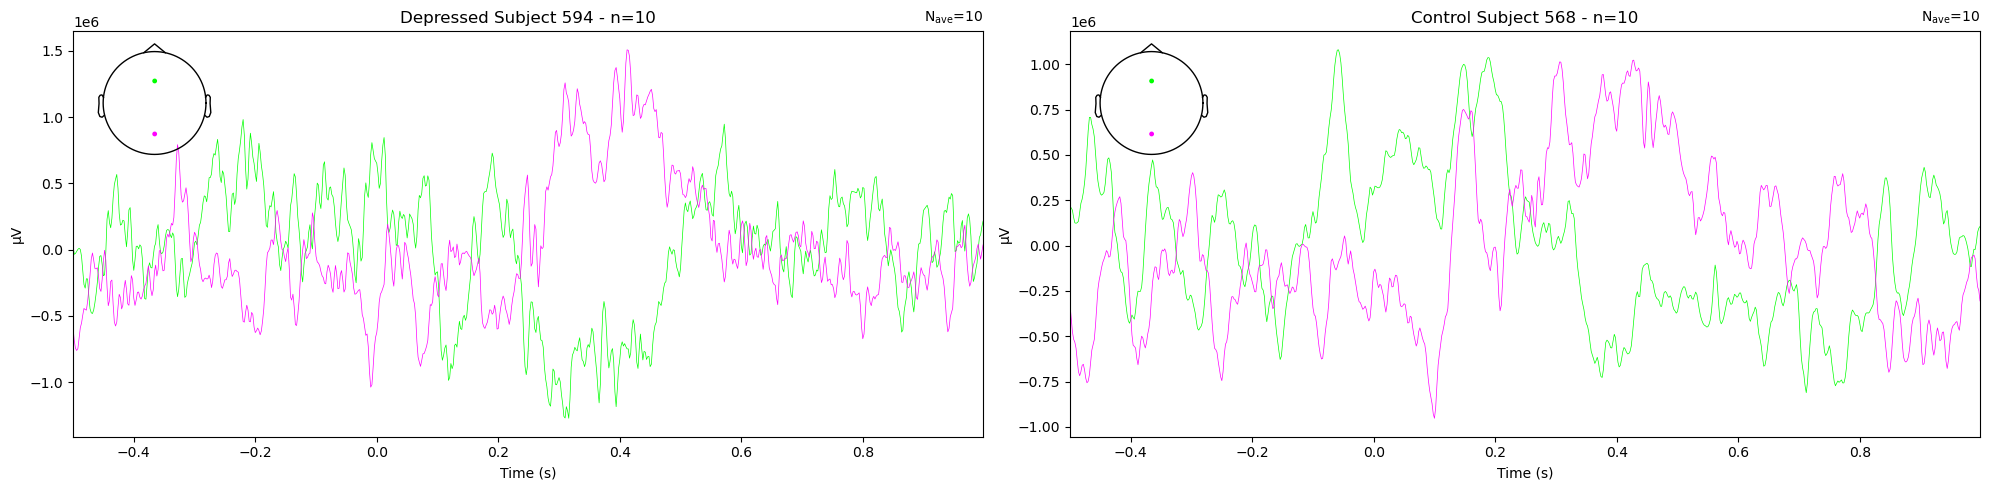

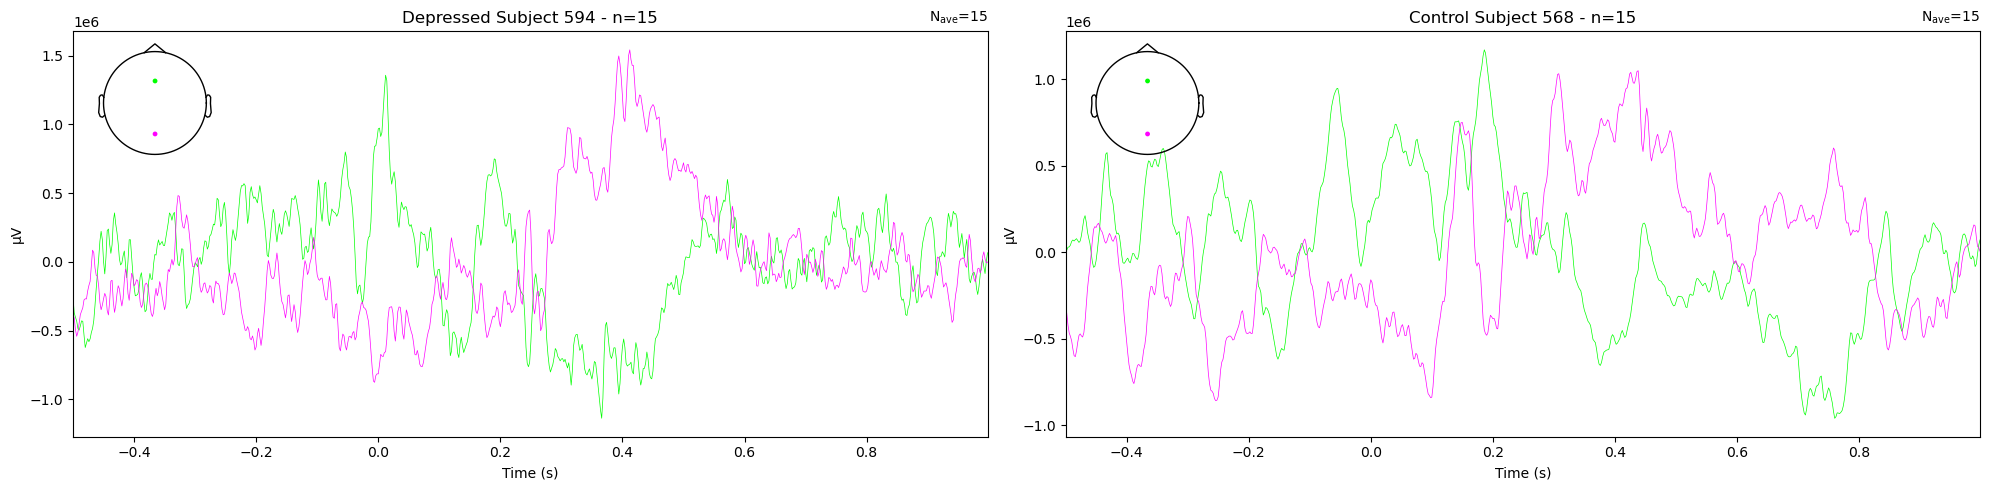

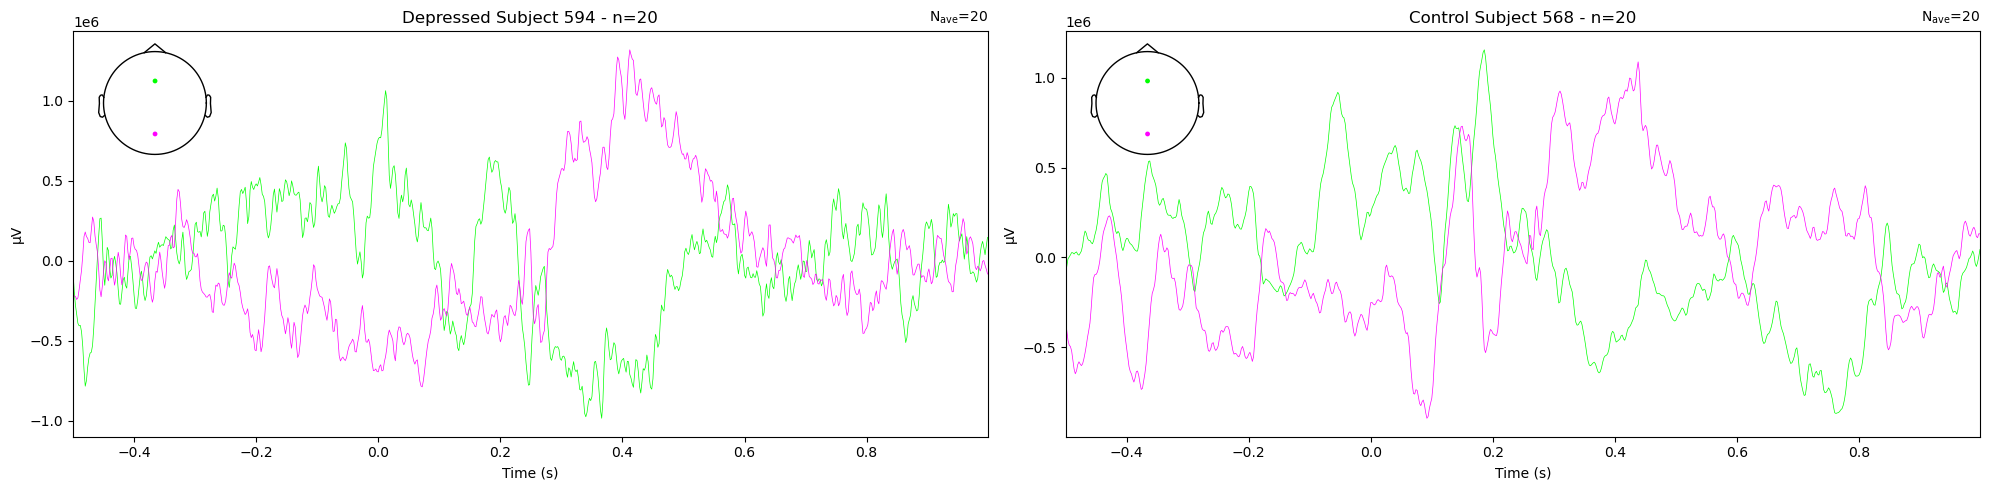

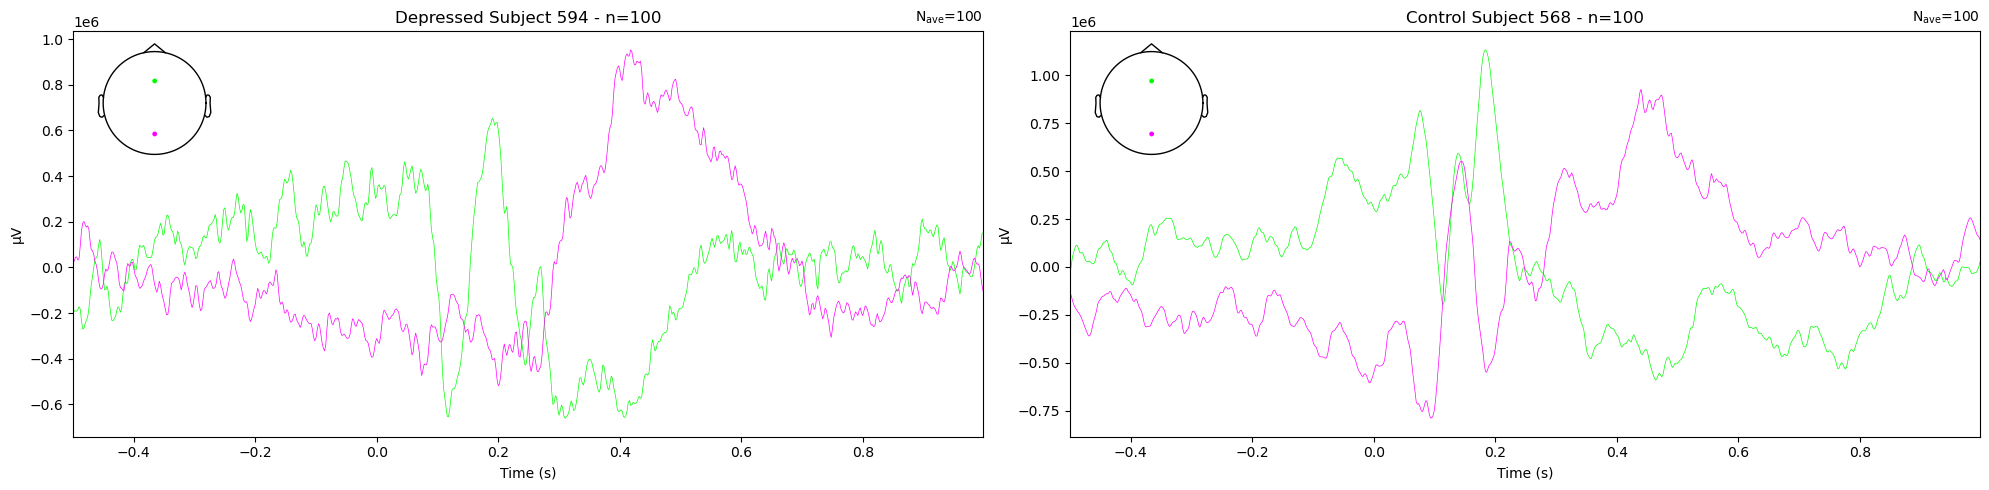

In [37]:
# List of n values for which we want to see the effect on ERP
n_values = [5, 10, 15, 20, 100]

# Example subjects and channels (FZ and PZ)
chosen_dep = 594
chosen_ctrl = 568
chosen_ch = ["FZ", "PZ"]

example_dep = all_data_zscore["depressed"]["stimulus"][chosen_dep]
example_ctrl = all_data_zscore["control"]["stimulus"][chosen_ctrl]

for n in n_values:
    erp_dep = ERP_onlist(example_dep, range(n))
    erp_ctrl = ERP_onlist(example_ctrl, range(n))
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    # Plot the ERP for the depressed subject (FZ and PZ)
    erp_dep.plot(picks=chosen_ch, axes=axes[0], show=False)
    axes[0].set_title(f"Depressed Subject {chosen_dep} - n={n}")
    
    # Plot the ERP for the control subject (FZ and PZ)
    erp_ctrl.plot(picks=chosen_ch, axes=axes[1], show=False)
    axes[1].set_title(f"Control Subject {chosen_ctrl} - n={n}")

    plt.tight_layout()
    plt.show()

# ERP on all subjects for punishment and reward
The following code stacks all punishment and reward epochs for a subject and calculates the ERP on all of them and plots all of them next to each other for comparison. Tha depressed subjects ERP are colored with cold colors while the control subjects ERP is colored with warm ones.

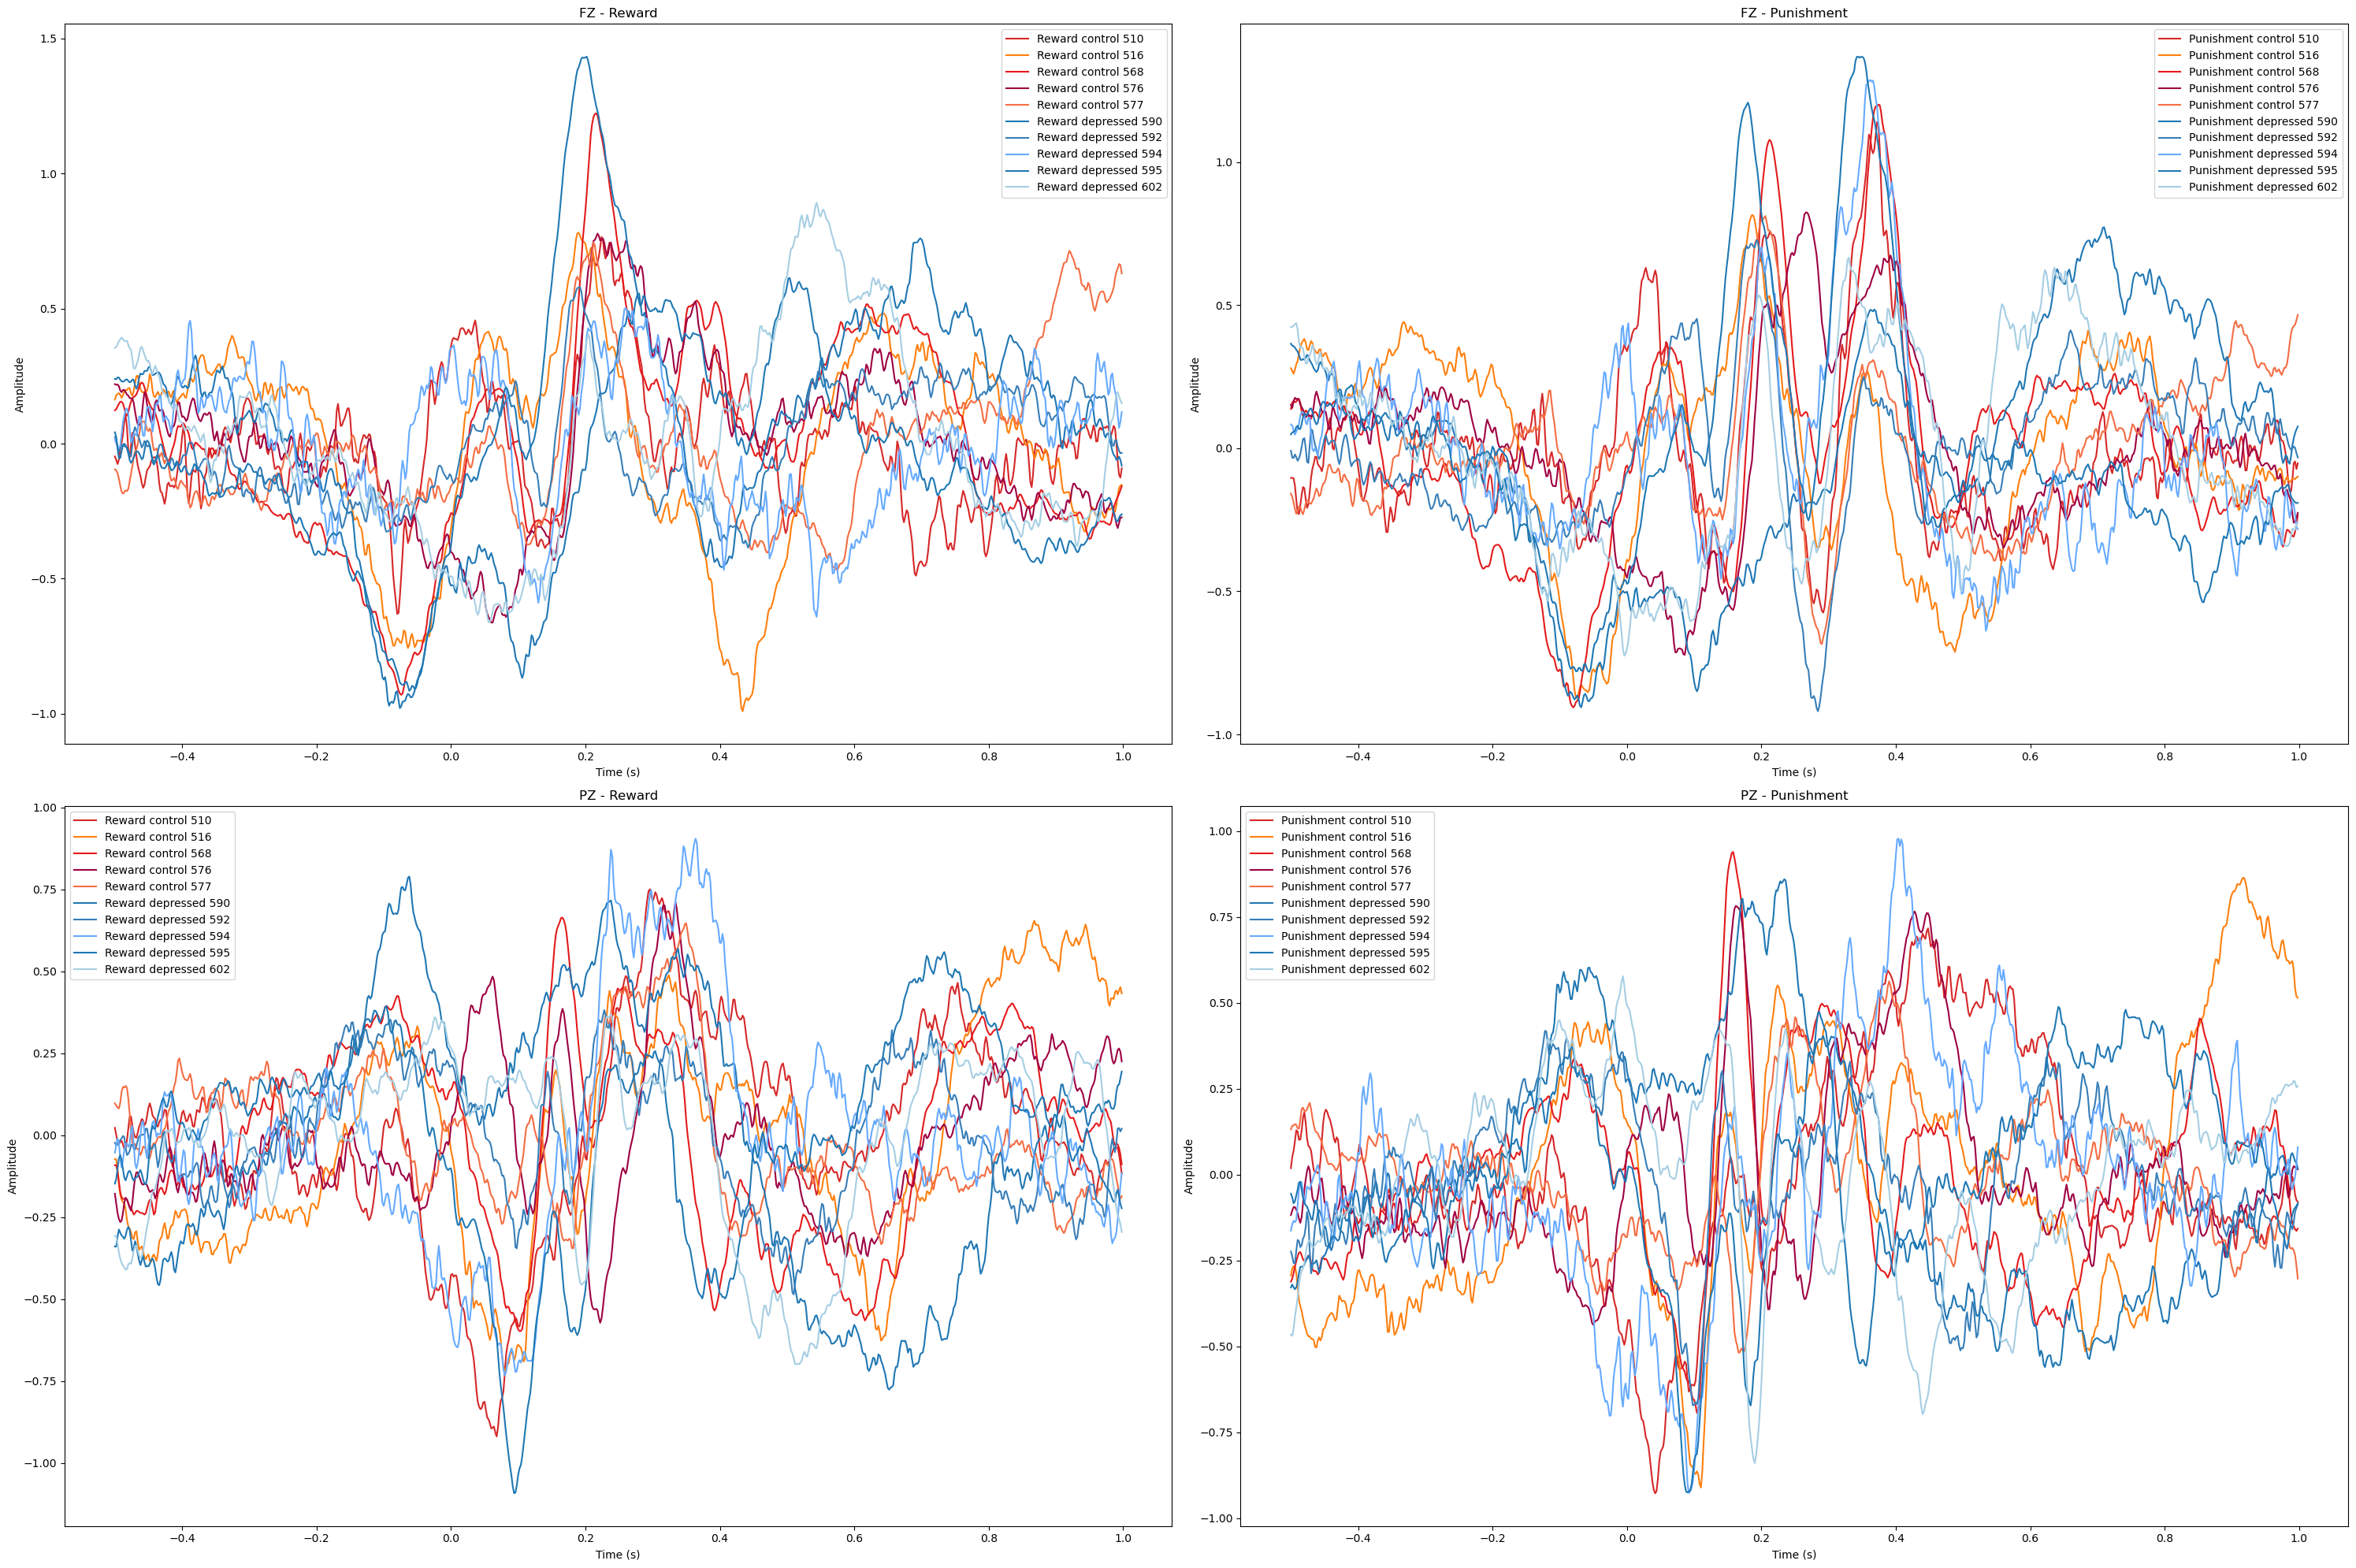

In [38]:
chosen_ch = ["FZ", "PZ"]

fz_reward = []
fz_punish = []
pz_reward = []
pz_punish = []
fz_reward_labels = []
fz_punish_labels = []
pz_reward_labels = []
pz_punish_labels = []

# colors for different subjects
control_colors = ['#d62728', '#ff7f0e', '#e41a1c', '#9e0142', '#f46d43']  # Different warm shades for control group
depressed_colors = ['#1f77b4', '#377eb8', '#66aaff', '#1f78b4', '#a6cee3']  # Different cool shades for depressed group


# Loop through groups and subjects
for group, indices in data_groups.items():
    for n_subject in indices:
        # Get the data for the current subject
        reward = all_data_zscore[group]["reward"][n_subject]
        punish = all_data_zscore[group]["punishment"][n_subject]
        
        reward_ERP = ERP_onlist(reward)
        punish_ERP = ERP_onlist(punish)
        
        # Pick FZ and PZ channels
        fz_reward.append(reward_ERP.copy().pick('FZ'))
        fz_punish.append(punish_ERP.copy().pick('FZ'))
        pz_reward.append(reward_ERP.copy().pick('PZ'))
        pz_punish.append(punish_ERP.copy().pick('PZ'))
        
        # Store labels for the legend (showing condition and subject number)
        fz_reward_labels.append(f"Reward {group} {n_subject}")
        fz_punish_labels.append(f"Punishment {group} {n_subject}")
        pz_reward_labels.append(f"Reward {group} {n_subject}")
        pz_punish_labels.append(f"Punishment {group} {n_subject}")

# Prepare the evokeds dictionary
evokeds = {
    'FZ - Reward': fz_reward,
    'FZ - Punishment': fz_punish,
    'PZ - Reward': pz_reward,
    'PZ - Punishment': pz_punish,
}

fig, axes = plt.subplots(2, 2, figsize=(30, 20))

# Plot each ERP in the corresponding subplot with unique color and line style for each subject
for idx, (evoked_data, labels, ax, title) in enumerate(zip([fz_reward, fz_punish, pz_reward, pz_punish], 
                                                           [fz_reward_labels, fz_punish_labels, pz_reward_labels, pz_punish_labels], 
                                                           axes.flatten(),
                                                           ['FZ - Reward', 'FZ - Punishment', 'PZ - Reward', 'PZ - Punishment'])):
    # Plot each subject with a unique color and line style based on their group
    for i, erp in enumerate(evoked_data):
        # Assign a unique color for each subject (based on group)
        if 'control' in labels[i]:
            color = control_colors[control_index.index(int(labels[i].split()[-1]))]      # Get color for control
        else:
            color = depressed_colors[depressed_index.index(int(labels[i].split()[-1]))]  # Get color for depressed
                    
        ax.plot(erp.times, erp.data.T, color=color, linestyle='-', label=labels[i])
    
    # Set the title and labels
    ax.set_title(title)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    
    # Add the legend
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

# Grand Average ERPs

---

The following code takes the grand average ERP of the response of all depressed and control subjects for reward and punishment and plots them next to each other for better comparison.
It also computes the Standard Error with ``compute_standard_error`` and fills the plots standard error range to show the probabilistic range of the data. 

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


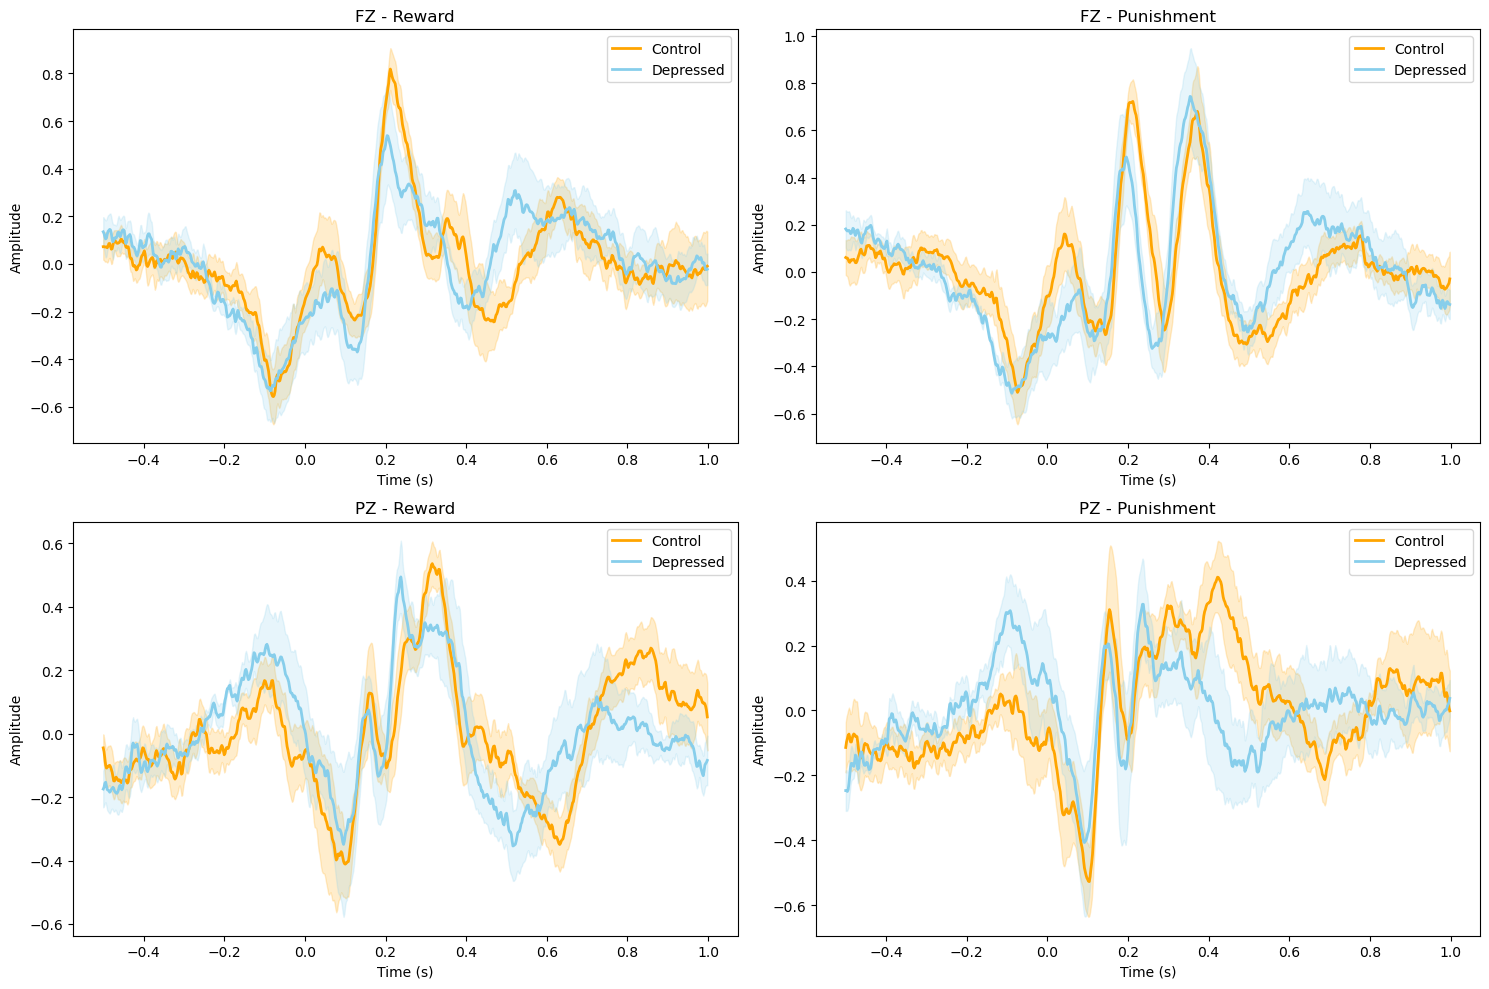

In [39]:
# Function to calculate standard error for each time point
def compute_standard_error(data):
    # Stack data from all subjects for each condition
    stacked_data = np.stack(data)
    return np.std(stacked_data, axis=0) / np.sqrt(stacked_data.shape[0])


# Extracting data for each channel, subject type and event
fz_reward_control_data = [fz_reward[i].data for i in range(len(fz_reward)) if 'control' in fz_reward_labels[i]]
fz_reward_depressed_data = [fz_reward[i].data for i in range(len(fz_reward)) if 'depressed' in fz_reward_labels[i]]

fz_punish_control_data = [fz_punish[i].data for i in range(len(fz_punish)) if 'control' in fz_punish_labels[i]]
fz_punish_depressed_data = [fz_punish[i].data for i in range(len(fz_punish)) if 'depressed' in fz_punish_labels[i]]

pz_reward_control_data = [pz_reward[i].data for i in range(len(pz_reward)) if 'control' in pz_reward_labels[i]]
pz_reward_depressed_data = [pz_reward[i].data for i in range(len(pz_reward)) if 'depressed' in pz_reward_labels[i]]

pz_punish_control_data = [pz_punish[i].data for i in range(len(pz_punish)) if 'control' in pz_punish_labels[i]]
pz_punish_depressed_data = [pz_punish[i].data for i in range(len(pz_punish)) if 'depressed' in pz_punish_labels[i]]


mean_fz_reward_control = mne.grand_average([fz_reward[i] for i in range(len(fz_reward)) if 'control' in fz_reward_labels[i]])
mean_fz_reward_depressed = mne.grand_average([fz_reward[i] for i in range(len(fz_reward)) if 'depressed' in fz_reward_labels[i]])
mean_fz_punish_control = mne.grand_average([fz_punish[i] for i in range(len(fz_punish)) if 'control' in fz_punish_labels[i]])
mean_fz_punish_depressed = mne.grand_average([fz_punish[i] for i in range(len(fz_punish)) if 'depressed' in fz_punish_labels[i]])

mean_pz_reward_control = mne.grand_average([pz_reward[i] for i in range(len(pz_reward)) if 'control' in pz_reward_labels[i]])
mean_pz_reward_depressed = mne.grand_average([pz_reward[i] for i in range(len(pz_reward)) if 'depressed' in pz_reward_labels[i]])
mean_pz_punish_control = mne.grand_average([pz_punish[i] for i in range(len(pz_punish)) if 'control' in pz_punish_labels[i]])
mean_pz_punish_depressed = mne.grand_average([pz_punish[i] for i in range(len(pz_punish)) if 'depressed' in pz_punish_labels[i]])


# Compute SE
fz_reward_control_se = compute_standard_error(fz_reward_control_data)
fz_reward_depressed_se = compute_standard_error(fz_reward_depressed_data)

fz_punish_control_se = compute_standard_error(fz_punish_control_data)
fz_punish_depressed_se = compute_standard_error(fz_punish_depressed_data)

pz_reward_control_se = compute_standard_error(pz_reward_control_data)
pz_reward_depressed_se = compute_standard_error(pz_reward_depressed_data)

pz_punish_control_se = compute_standard_error(pz_punish_control_data)
pz_punish_depressed_se = compute_standard_error(pz_punish_depressed_data)

time = fz_reward[0].times  # Time vector is consistent across ERPs

fig, axes_compare = plt.subplots(2, 2, figsize=(15, 10))  # 2x2 layout

# Function to plot with SE
def plot_with_se(ax, time, mean_data, se_data, color, label, linestyle='-'):
    ax.plot(time, mean_data, color=color, label=label, linestyle=linestyle, linewidth=2)
    ax.fill_between(time, mean_data - se_data, mean_data + se_data, color=color, alpha=0.2)

# Define titles and plot for each subplot
titles = ["FZ - Reward", "FZ - Punishment", "PZ - Reward", "PZ - Punishment"]
control_averages = [
    mean_fz_reward_control.data[0], mean_fz_punish_control.data[0],
    mean_pz_reward_control.data[0], mean_pz_punish_control.data[0]
]
depressed_averages = [
    mean_fz_reward_depressed.data[0], mean_fz_punish_depressed.data[0],
    mean_pz_reward_depressed.data[0], mean_pz_punish_depressed.data[0]
]
control_ses = [fz_reward_control_se[0], fz_punish_control_se[0], pz_reward_control_se[0], pz_punish_control_se[0]]
depressed_ses = [fz_reward_depressed_se[0], fz_punish_depressed_se[0], pz_reward_depressed_se[0], pz_punish_depressed_se[0]]

colors = {"Control": "orange", "Depressed": "#87CEEB"}

for i, ax in enumerate(axes_compare.flatten()):
    plot_with_se(ax, time, control_averages[i], control_ses[i], colors["Control"], "Control")
    plot_with_se(ax, time, depressed_averages[i], depressed_ses[i], colors["Depressed"], "Depressed", linestyle="-")
    ax.set_title(titles[i])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.legend()

plt.tight_layout()
plt.show()


# Frequncy Analysis with STFT (Short Time Fourier Transform)
In the following sections we compute the STFT on different brain frequnecy bands and plot them for FZ a channel of depressed and control subjects in
response to punishment and reward events.

---

The plots are normalized and their mean is subtracted because we wanted to see the changes and also wanted to scale them for better visualization.

In [40]:
# Frequency bands
frequency_bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 100),
}

f_windows = {
    "Delta": 0.5,
    "Theta": 0.5,
    "Alpha": 0.5,
    "Beta": 0.5,
    "Gamma": 0.5,
}

# STFT function with step parameter
def compute_band_power(epochs, band_limits, sample_rate=500, window_size=0.5, step=0.1):
    """
    Compute band power for a given frequency band and epochs using a sliding window.
    
    Parameters:
    - epochs: Epoch data (n_epochs x n_channels x n_times)
    - band_limits: Tuple of (low, high) frequency band
    - sample_rate: Sampling frequency of data
    - window_size: STFT window size in seconds
    - step: Step size in seconds for sliding the window
    
    Returns:
    - band_powers: Mean power for the specified band over time (n_epochs x n_time_windows)
    - times: Array of time points corresponding to the center of each window
    """
    band_powers = []
    window_samples = int(window_size * sample_rate)
    step_samples = int(step * sample_rate)
    
    for epoch in epochs:
        # Compute STFT for each channel in the epoch and store band power
        channel_band_powers = []
        for channel_data in epoch:
            f, t, Sxx = spectrogram(
                channel_data,
                fs = sample_rate,
                nperseg = window_samples,
                noverlap = window_samples - step_samples,
                mode='psd'
            )
            # Select frequency band
            band_idx = (f >= band_limits[0]) & (f <= band_limits[1])
            band_power = Sxx[band_idx].mean(axis=0)  # Mean power over band frequencies
            band_power = (band_power - np.mean(band_power))/np.std(band_power)
            
            channel_band_powers.append(band_power)
        
        # Average across channels
        mean_band_power = np.mean(channel_band_powers, axis=0)
        band_powers.append(mean_band_power)
    
    band_powers = np.array(band_powers)  # Shape: (n_epochs, n_time_windows)
    times = t  # Time points are consistent across epochs
    
    return band_powers, times

# Extract and process condition/group data
def extract_epochs(data, group, condition):
    """
    Extract epochs for a specific group and condition.
    
    Parameters:
    - all_data: Dictionary containing all data
    - group: Group name ('control' or 'depressed')
    - condition: Condition name ('reward' or 'punishment')
    
    Returns:
    - epochs_list: List of epochs (n_epochs x n_channels x n_times)
    """
    epochs_list = []
    for subject_id, epochs in data[group][condition].items():
        epochs_data = epochs.get_data()  # Convert MNE Epochs object to NumPy array
        epochs_list.extend(epochs_data)  # Add all epochs for this subject
    return np.array(epochs_list)

# Process and analyze data for each condition and group
def process_condition_group(epochs, sample_rate=500, step=0.1):
    """
    Compute mean and SE of power for all frequency bands for a condition and group.
    
    Parameters:
    - epochs: List of epochs (n_epochs x n_channels x n_times)
    - sample_rate: Sampling frequency
    - window_size: STFT window size in seconds
    - step: Step size in seconds for sliding the window
    
    Returns:
    - mean_powers: Dictionary of mean power for each band
    - se_powers: Dictionary of standard error for each band
    - times: Array of time points corresponding to the center of each window
    """
    mean_powers = {}
    se_powers = {}
    times = None  # Initialize times
    
    for (band, limits), (_, win_siz) in zip(frequency_bands.items(), f_windows.items()):
        band_powers, t = compute_band_power(epochs, limits, sample_rate, win_siz, step)
        mean_powers[band] = band_powers.mean(axis=0)  # Mean across epochs
        se_powers[band] = band_powers.std(axis=0) / np.sqrt(band_powers.shape[0])  # SE across epochs
        if times is None:
            times = t  # Set times once
    
    return mean_powers, se_powers, times

# Plot function
def plot_band_changes(time, mean_powers, se_powers, title):
    """
    Plot mean power and standard error for each band.
    
    Parameters:
    - time: Time points
    - mean_powers: Mean power dictionary
    - se_powers: SE dictionary
    - title: Title of the plot
    """
    plt.figure(figsize=(12, 6))
    for band in frequency_bands.keys():
        plt.plot(time, mean_powers[band], label=f'{band} (mean)', linewidth=2)
        plt.fill_between(
            time, 
            mean_powers[band] - se_powers[band], 
            mean_powers[band] + se_powers[band], 
            alpha=0.3, 
            label=f'{band} (SE)'
        )
    
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Power (µV²/Hz)')
    plt.legend()
    plt.show()


The following code uses the function developed in previous cell to plot the data for each subject and event type

Processing reward - control...


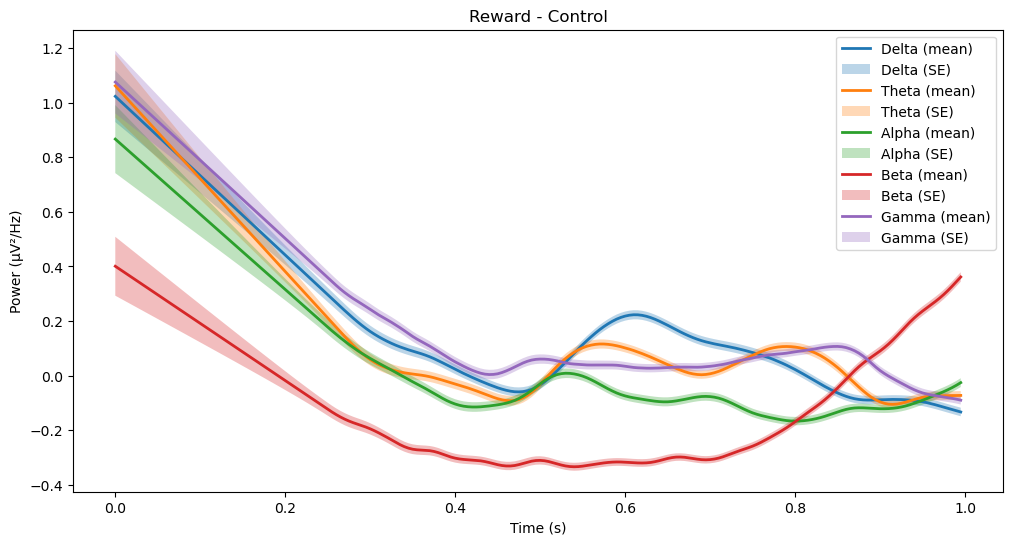

Processing reward - depressed...


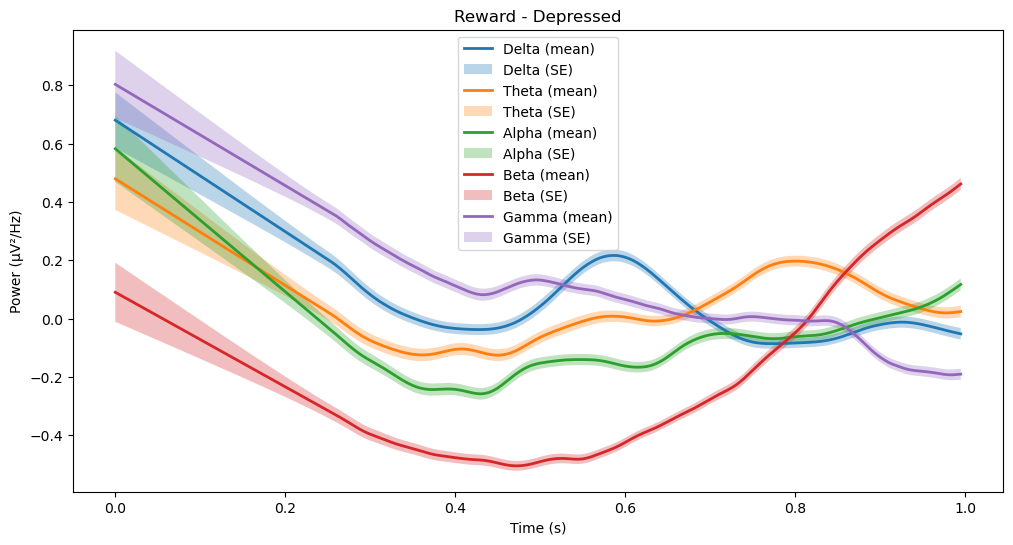

Processing punishment - control...


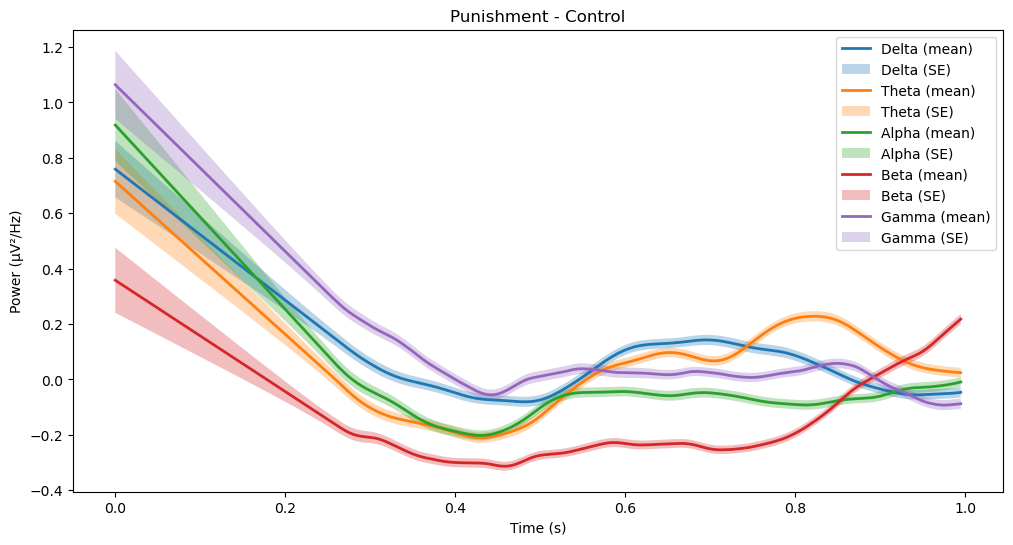

Processing punishment - depressed...


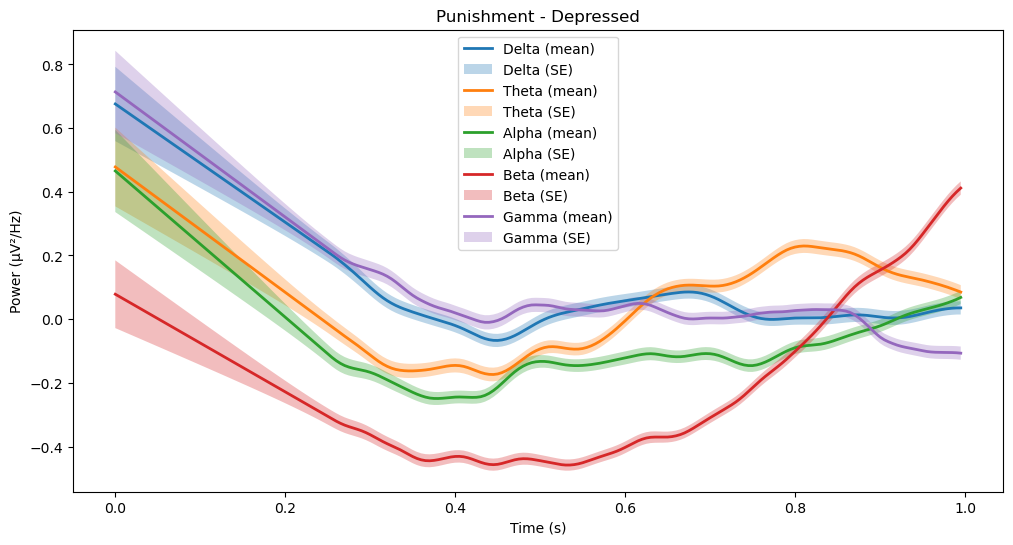

In [41]:
# Define a common time grid
def get_common_time_grid(sample_rate, epoch_length, step=0.005):
    """
    Create a common time grid for all frequency bands based on the step size.
    
    Parameters:
    - sample_rate: Sampling frequency
    - epoch_length: Length of the epoch in seconds
    - step: Desired step size in seconds
    
    Returns:
    - common_times: Array of time points for the common grid
    """
    return np.arange(0, epoch_length, step)

# Resample band power onto a common time grid
def resample_band_power(band_power, original_times, common_times):
    """
    Resample band power data to a common time grid using interpolation.
    
    Parameters:
    - band_power: Array of band powers (n_epochs x n_time_windows)
    - original_times: Original time points corresponding to the band power
    - common_times: Common time grid to resample onto
    
    Returns:
    - resampled_power: Resampled band power (n_epochs x len(common_times))
    """
    resampled_power = []
    for epoch_power in band_power:
        f_interp = interp1d(original_times, epoch_power, kind='linear', fill_value="extrapolate")
        resampled_power.append(f_interp(common_times))
    return np.array(resampled_power)

# Update the compute_band_power function to handle resampling
def compute_band_power2(epochs, band_limits, sample_rate, window_size, step, common_times):
    """
    Compute band power and resample onto a common time grid.
    """
    band_powers, original_times = compute_band_power(epochs, band_limits, sample_rate, window_size, step)
    resampled_powers = resample_band_power(band_powers, original_times, common_times)
    return resampled_powers, common_times

# Modify process_condition_group to use a common time grid
def process_condition_group(epochs, sample_rate, step, common_times):
    """
    Compute mean and SE of power for all frequency bands, resampled onto a common grid.
    """
    mean_powers = {}
    se_powers = {}
    
    for (band, limits), (_, win_siz) in zip(frequency_bands.items(), f_windows.items()):
        band_powers, common_times = compute_band_power2(epochs, limits, sample_rate, win_siz, step, common_times)
        mean_powers[band] = band_powers.mean(axis=0)  # Mean across epochs
        se_powers[band] = band_powers.std(axis=0) / np.sqrt(band_powers.shape[0])  # SE across epochs
    
    return mean_powers, se_powers, common_times

# Update analyze_and_plot to define a common grid
def analyze_and_plot(data, sample_rate=500, step=0.005):
    """
    Analyze and plot power changes for each group and condition on a common time grid.
    """
    epoch_length = data["control"]["reward"][list(data["control"]["reward"].keys())[0]].tmax
    common_times = get_common_time_grid(sample_rate, epoch_length, step)
    
    for condition in ["reward", "punishment"]:
        for group in ["control", "depressed"]:
            print(f"Processing {condition} - {group}...")
            epochs = extract_epochs(data, group, condition)
            mean_powers, se_powers, times = process_condition_group(
                epochs, sample_rate, step, common_times
            )
            title = f'{condition.capitalize()} - {group.capitalize()}'
            plot_band_changes(times, mean_powers, se_powers, title)

analyze_and_plot(all_data_zscore)

The following code plots by band instead of plotting by subject and event type which is more useful since we want to see the changes in bands

Processing reward - control...
Processing reward - depressed...
Processing punishment - control...
Processing punishment - depressed...


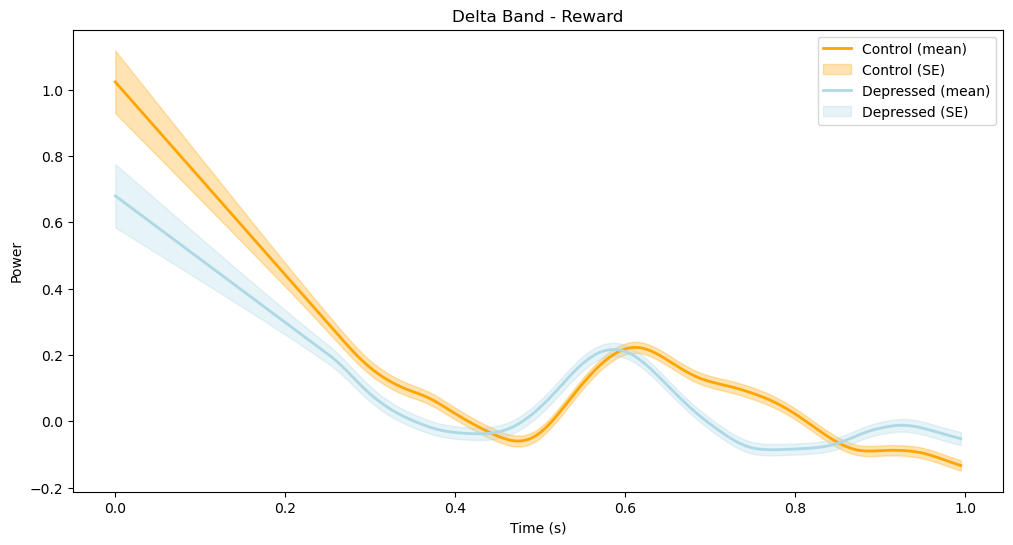

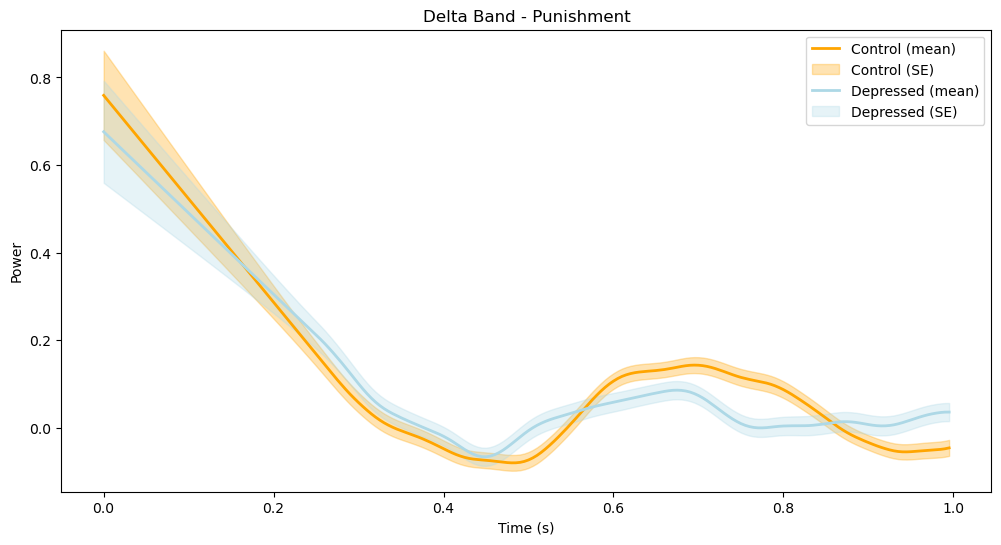

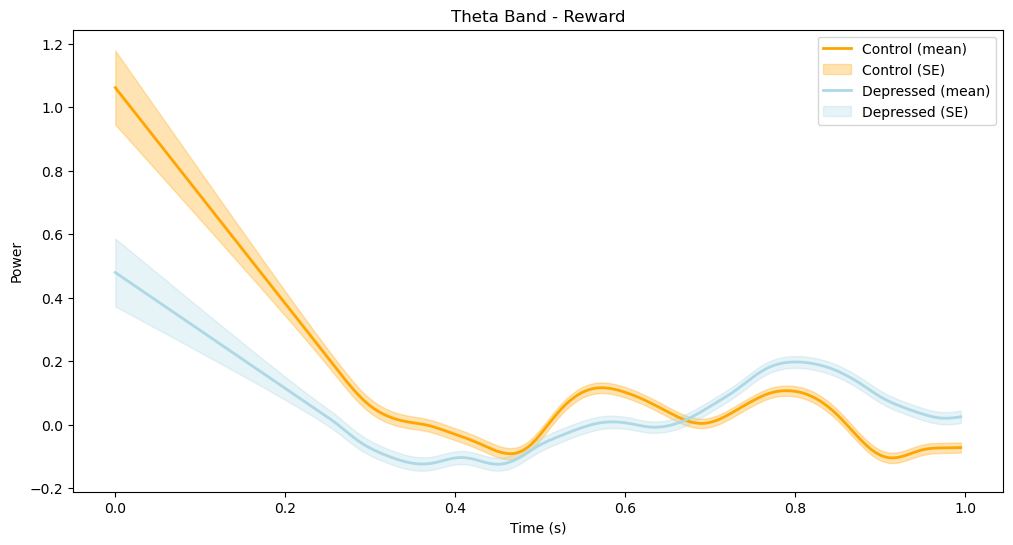

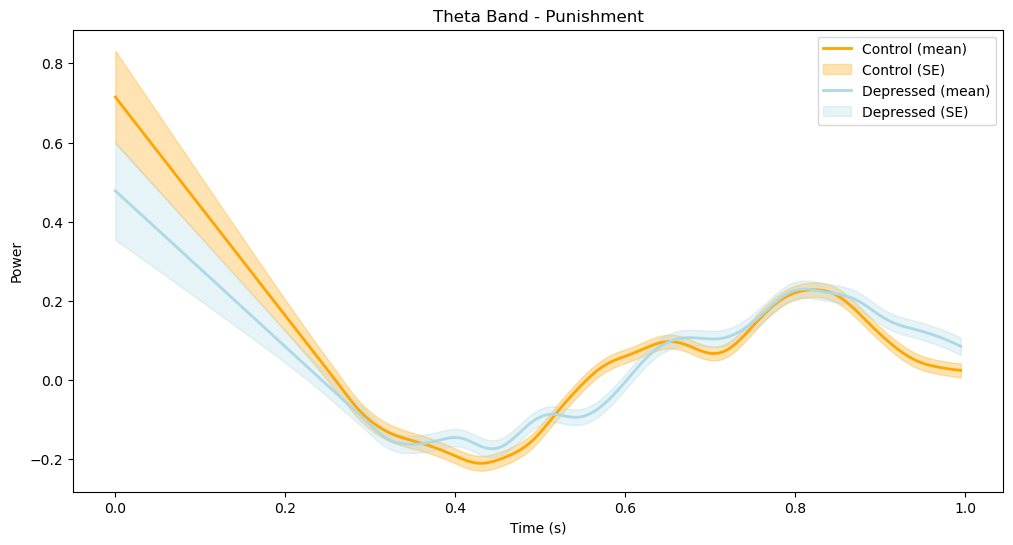

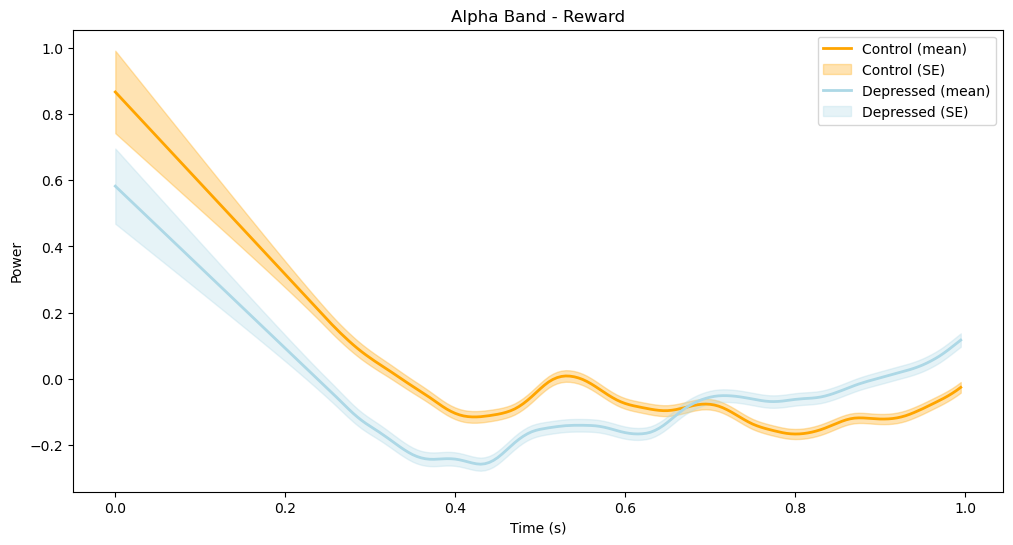

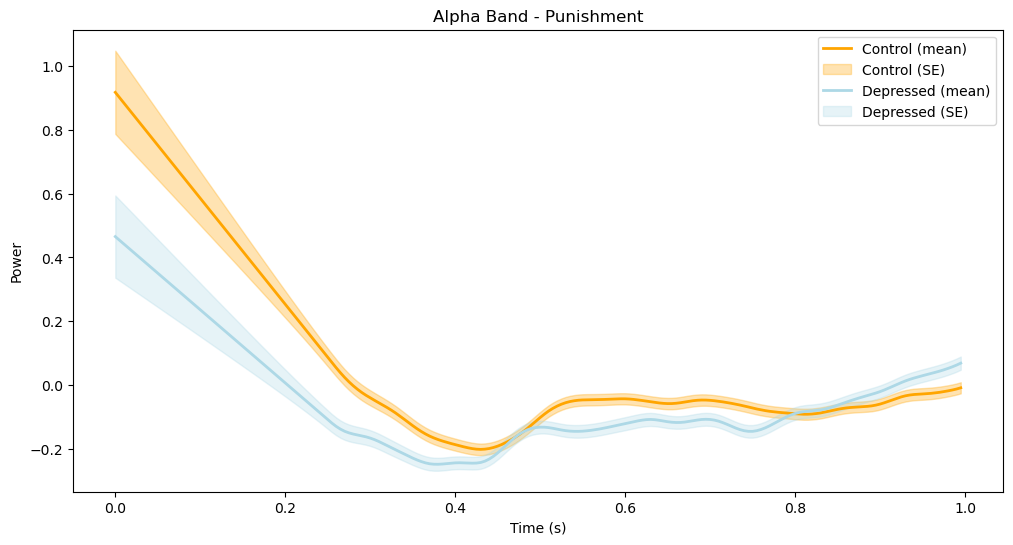

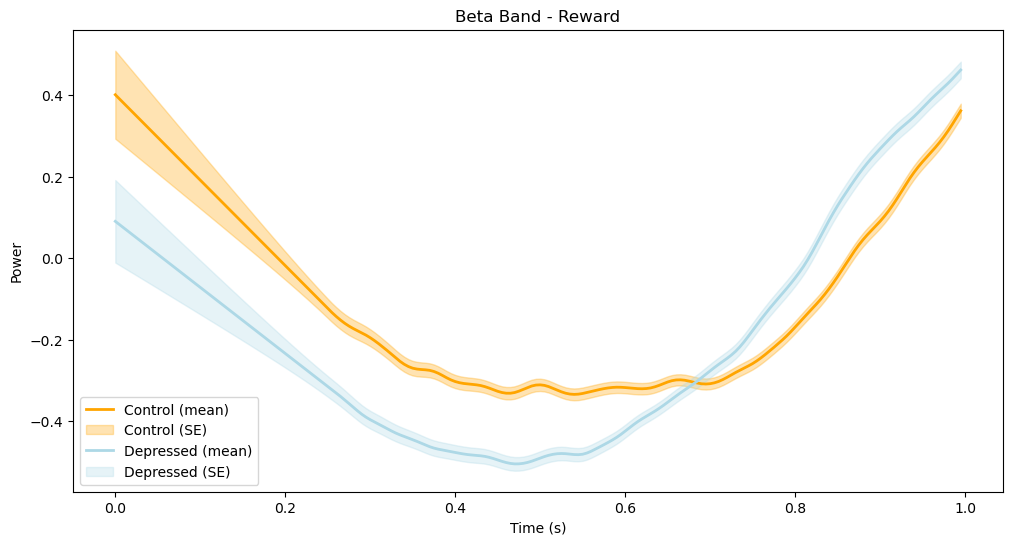

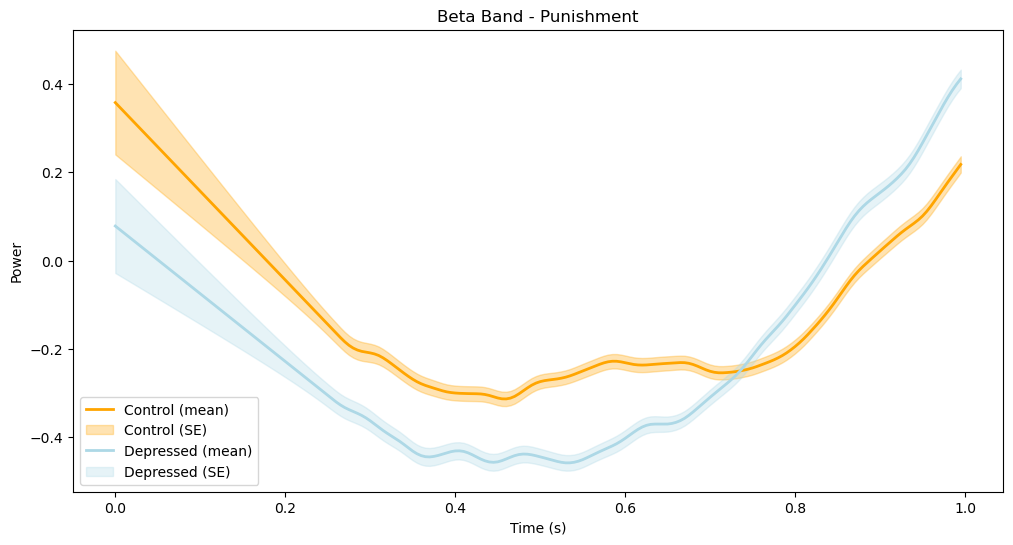

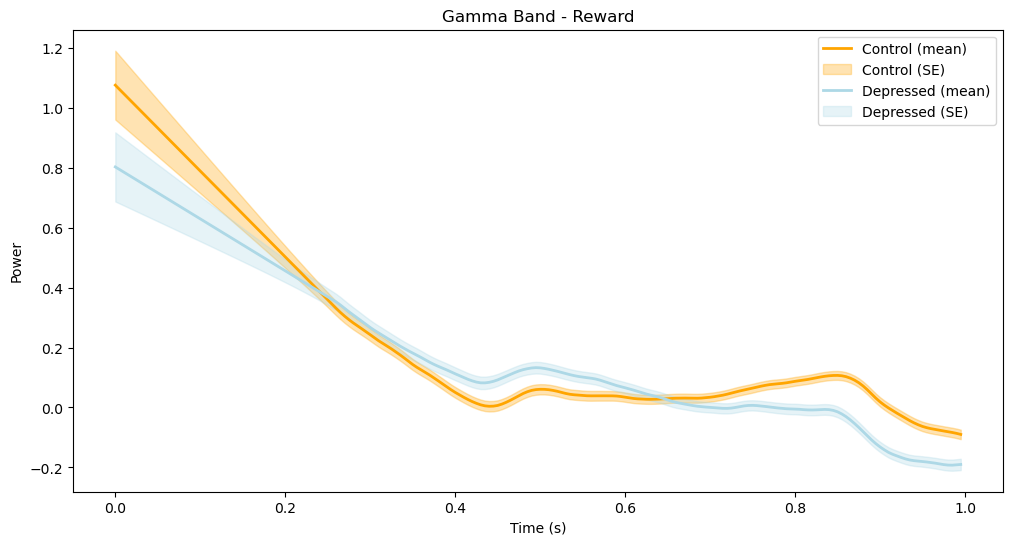

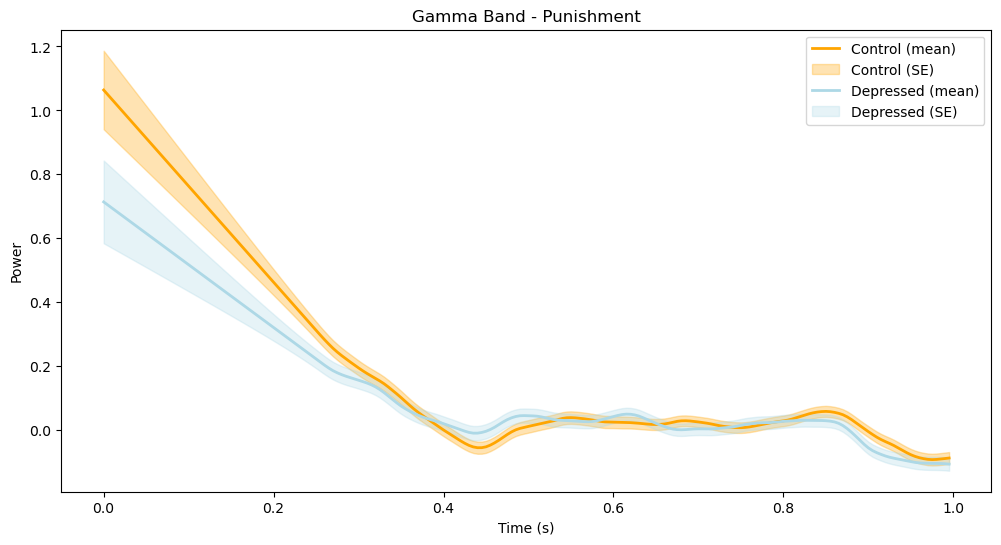

In [42]:
def plot_separate_band_condition(common_times, mean_powers_group, se_powers_group):
    """
    Plot mean power and SE for each frequency band and condition separately with custom colors.
    
    Parameters:
    - common_times: Common time grid for all bands
    - mean_powers_group: Dictionary of mean powers for each group and condition
    - se_powers_group: Dictionary of SEs for each group and condition
    """
    colors = {"control": "orange", "depressed": "lightblue"}
    
    for band in frequency_bands.keys():
        for condition in ["reward", "punishment"]:
            plt.figure(figsize=(12, 6))
            for group in ["control", "depressed"]:
                label = f'{group.capitalize()}'
                mean_power = mean_powers_group[condition][group][band]
                se_power = se_powers_group[condition][group][band]
                
                plt.plot(
                    common_times, 
                    mean_power, 
                    label=f'{label} (mean)', 
                    linewidth=2, 
                    color=colors[group]
                )
                plt.fill_between(
                    common_times,
                    mean_power - se_power,
                    mean_power + se_power,
                    alpha=0.3,
                    color=colors[group],
                    label=f'{label} (SE)'
                )
            
            plt.title(f'{band} Band - {condition.capitalize()}')
            plt.xlabel('Time (s)')
            plt.ylabel('Power')
            plt.legend()
            plt.show()

# Main analysis function
def analyze_and_plot_by_band(data, sample_rate=500, step=0.005):
    epoch_length = data["control"]["reward"][list(data["control"]["reward"].keys())[0]].tmax
    common_times = get_common_time_grid(sample_rate, epoch_length, step)
    
    # Dictionaries to hold mean and SE powers for all groups and conditions
    mean_powers_group = {condition: {group: {} for group in ["control", "depressed"]} for condition in ["reward", "punishment"]}
    se_powers_group = {condition: {group: {} for group in ["control", "depressed"]} for condition in ["reward", "punishment"]}
    
    for condition in ["reward", "punishment"]:
        for group in ["control", "depressed"]:
            print(f"Processing {condition} - {group}...")
            epochs = extract_epochs(data, group, condition)
            mean_powers, se_powers, common_times = process_condition_group(
                epochs, sample_rate, step, common_times
            )
            for band in frequency_bands.keys():
                mean_powers_group[condition][group][band] = mean_powers[band]
                se_powers_group[condition][group][band] = se_powers[band]
    
    # Generate plots for each band-condition combination
    plot_separate_band_condition(common_times, mean_powers_group, se_powers_group)

analyze_and_plot_by_band(all_data_zscore)